Alexandra Andira<br>
JCDS-2804-015
# **New York City Taxi Rides: A Study on Green Taxi**

## **About**

The New York City Taxi and Limousine Commission (TLC), created in 1971, is the agency responsible for licensing and regulating New York City's medallion (yellow) taxis, street hail livery (green) taxis, for-hire vehicles (FHVs), commuter vans, and paratransit vehicles. The TLC collects trip record information for each taxi and for-hire vehicle trip completed by our licensed drivers and vehicles.
TCL receive taxi trip data from the technology service providers (TSPs) that provide electronic metering in each cab, and FHV trip data from the app, community livery, black car, or luxury limousine company, or base, who dispatched the trip. 

In each trip record dataset, one row represents a single trip made by a TLC-licensed vehicle.

This dataset contains green taxi trip records. Green taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). The trip data was not created by the TLC, and TLC makes no representations as to the accuracy of these data.

## **Description of the dataset**
| Column Name         |Description  | API Field Name | Data Type |
|:-------------------:|:------------|:--------------:|:---------:|
|VendorID|A code indicating the TPEP provider that provided the record.|vendorid|Number|
|lpep_pickup_datetime|The date and time when the meter was engaged.|lpep_pickup_datetime|Floating Timestamp|
|lpep_dropoff_datetime|The date and time when the meter was disengaged.|lpep_dropoff_datetime|Floating Timestamp|
|store_and_fwd_flag|This flag indicates whether the trip record was held in vehicle before sending to the vendor, aka "store and forward", because the vehicle did not have a connection to the server.|store_and_fwd_flag|Text|
|RatecodeID|The final rate code in effect at the end of the trip.|ratecodeid|Number|
|PULocationID|TLC Taxi Zone in which the taximeter was engaged.|pulocationid|Number|
|DOLocationID|TLC Taxi Zone in which the taximeter was disengaged.|dolocationid|Number|
|passenger_count|The number of passengers in the vehicle.|passenger_count|Number|
|trip_distance|The elapsed trip distancen in miles reported by the taximeter.|trip_distance|Number|
|fare_amount|The time-and-distance fare calculated by the meter. For additional information on the following columns.|fare_amount|Number|
|extra|Miscellaneous extras and surcharges.|extra|Number|
|mta_tax|Tax that is automatically triggered based on the metered rate in use.|mta_tax|Number|
|tip_amount|This field is automatically populated for credit card tips. Cash tips are not included.|tip_amount|Number|
|tolls_amount|Total amount of all tolls paid in trip.|tolls_amount|Number|
|ehail_fee|*Currently unused*|ehail_fee|Text|
|improvement_surcharge|Improvement surcharge assessed trips at the flag drop.|improvement_surcharge|Number|
|total_amount|The total amount charged to passengers. Does not include cash tips.|total_amount|Number|
|payment_type|A numeric code signifying how the passenger paid for the trip.|payment_type|Number|
|trip_type|A code indicating whether the trip was a street-hail or a dispatch that is automatically assigned based on the metered rate in use but can be altered by the driver.|trip_type|Number|
|congestion_surcharge|Total amount collected in trip for NYS congestion surcharge.|congestion_surcharge|Number|

## **Research Questions**
Here are some research questions categorized by theme:
1. **Trip Patterns and Demand Analysis**
    1. When are NYC taxis most in demand? (Analyze peak hours, days, or seasons.)
    2. Which locations have the highest number of pickups and drop-offs? (Identify taxi hotspots.)
    3. How do trip distance vary by borough or zone? (Compare Manhattan vs Brooklyn, etc.)
    4. Do longer trips occur more frequently at night?
2. **Pricing and Fare Analysis** <br>
    What factors influence total fare the most? (Trip distance, location, congestion surcharge, etc.)

3. **Payment Behavior and Tip Patterns**
    1. Do passengers tip more for longer trips or for certain times of the day?
    2. How do tip amounts vary by borough?

## **Importing necessary libraries**

In [1]:
import math
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import geopandas as gpd

import matplotlib as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## **Importing dataset**

In [2]:
# Load the main dataset
nyc = pd.read_csv('C:/Users/Dell/Documents/Purwadhika/Module 2 - Data Analysis/CAPSTONE MODULE 2/NYC TLC Trip Record.csv')

In [3]:
# Load the taxi zone shapefile
zone = gpd.read_file('C:/Users/Dell/Documents/Purwadhika/Module 2 - Data Analysis/CAPSTONE MODULE 2/taxi_zones/taxi_zones.shp')

In [4]:
# Load the weather dataset
weather = pd.read_csv('C:/Users/Dell/Documents/Purwadhika/Module 2 - Data Analysis/CAPSTONE MODULE 2/weather_2009-2023.csv')

## **Skimming the dataset**

In [5]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               68211 non-null  int64  
 1   lpep_pickup_datetime   68211 non-null  object 
 2   lpep_dropoff_datetime  68211 non-null  object 
 3   store_and_fwd_flag     63887 non-null  object 
 4   RatecodeID             63887 non-null  float64
 5   PULocationID           68211 non-null  int64  
 6   DOLocationID           68211 non-null  int64  
 7   passenger_count        63887 non-null  float64
 8   trip_distance          68211 non-null  float64
 9   fare_amount            68211 non-null  float64
 10  extra                  68211 non-null  float64
 11  mta_tax                68211 non-null  float64
 12  tip_amount             68211 non-null  float64
 13  tolls_amount           68211 non-null  float64
 14  ehail_fee              0 non-null      float64
 15  im

Using the `.info()` function, we know that there are a total of 20 features in this dataset, before cleaning. There is one feature, `ehail_fee` that only contain null values. This feature will be dropped during cleaning. Features `store_and_fwd_flag`, `RatecodeID`, `passenger_count`, `payment_type`, `trip_type`, `congestion_surcharge` also contain null values. These rows of entries later on will also be dropped during cleaning.

In [6]:
nyc.head(10)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.00,0.5,4.03,0.0,NaN,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.00,0.5,2.64,0.0,NaN,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.00,0.5,1.94,0.0,NaN,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.50,1.5,1.70,0.0,NaN,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.50,1.5,0.00,0.0,NaN,1.0,8.00,1.0,1.0,0.00
5,2,2023-01-01 00:53:31,2023-01-01 01:11:04,N,1.0,41,262,1.0,2.78,17.7,1.00,0.5,0.00,0.0,NaN,1.0,22.95,2.0,1.0,2.75
6,1,2023-01-01 00:09:14,2023-01-01 00:26:39,N,1.0,181,45,2.0,3.80,19.1,3.75,1.5,4.85,0.0,NaN,1.0,29.20,1.0,1.0,2.75
7,2,2023-01-01 00:11:58,2023-01-01 00:24:55,N,1.0,24,75,1.0,1.88,14.2,1.00,0.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00
8,2,2023-01-01 00:41:29,2023-01-01 00:46:26,N,1.0,41,166,2.0,1.11,7.2,1.00,0.5,1.00,0.0,NaN,1.0,10.70,1.0,1.0,0.00
9,2,2023-01-01 00:50:32,2023-01-01 01:13:42,N,1.0,24,140,1.0,4.22,24.7,1.00,0.5,3.00,0.0,NaN,1.0,32.95,1.0,1.0,2.75


In [7]:
nyc.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,68211.000000,63887.000000,68211.000000,68211.000000,63887.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,0.0,68211.000000,68211.000000,63887.000000,63877.000000,63887.000000
mean,1.863028,1.117160,98.549735,138.429901,1.315870,8.114852,16.603545,0.825431,0.588340,2.139012,0.169627,NaN,0.951625,21.789377,1.373613,1.021933,0.726748
std,0.343820,1.372913,61.244314,76.761311,0.979054,585.105955,13.470121,1.269904,0.385819,3.052710,1.099789,NaN,0.196875,15.457115,0.508039,0.146465,1.212836
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-70.000000,-2.500000,-0.500000,-10.500000,0.000000,NaN,-1.000000,-71.500000,1.000000,1.000000,-2.750000
25%,2.000000,1.000000,74.000000,74.000000,1.000000,1.110000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,12.900000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,75.000000,138.000000,1.000000,1.850000,13.500000,0.000000,0.500000,1.600000,0.000000,NaN,1.000000,17.900000,1.000000,1.000000,0.000000
75%,2.000000,1.000000,129.000000,219.000000,1.000000,3.210000,19.800000,1.000000,0.500000,3.330000,0.000000,NaN,1.000000,26.150000,2.000000,1.000000,2.750000
max,2.000000,99.000000,265.000000,265.000000,9.000000,120098.840000,490.000000,12.500000,2.750000,222.220000,36.050000,NaN,1.000000,491.000000,5.000000,2.000000,2.750000


In [8]:
nyc.apply(pd.Series.nunique)

VendorID                     2
lpep_pickup_datetime     66575
lpep_dropoff_datetime    66519
store_and_fwd_flag           2
RatecodeID                   6
PULocationID               226
DOLocationID               249
passenger_count             10
trip_distance             1870
fare_amount               2553
extra                       16
mta_tax                      6
tip_amount                1492
tolls_amount                26
ehail_fee                    0
improvement_surcharge        5
total_amount              4670
payment_type                 5
trip_type                    2
congestion_surcharge         4
dtype: int64

In [9]:
nyc.isnull().sum()

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag        4324
RatecodeID                4324
PULocationID                 0
DOLocationID                 0
passenger_count           4324
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                68211
improvement_surcharge        0
total_amount                 0
payment_type              4324
trip_type                 4334
congestion_surcharge      4324
dtype: int64

There are some features that have less than 10 unique values. These features are:
- `VendorID`
- `store_and_fwd_flag`
- `RatecodeID`
- `passenger_count`
- `mta_tax`
- `improvement_surcharge`
- `payment_type`
- `trip_type`
- `congestion_surcharge`

### Exploring `nyc` features with less than 10 unique values

#### `VendorID`<br>

A code indicating the LPEP provider that provided the record.

1 = Creative Mobile Technologies, LLC.<br>
2 = VeriFone Inc.

In [10]:
nyc['VendorID'].unique()

array([2, 1])

In [11]:
nyc['VendorID'].value_counts(normalize = True, ascending = False, dropna = False).mul(100).round(2)

VendorID
2    86.3
1    13.7
Name: proportion, dtype: float64

This feature contains 58,868 entries of 2 and 9,343 entries of 1. There are no null values present in this feature.

#### `store_and_fwd_flag`<br>

This flag indicates whether the trip record was held in the vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.

Y = store and forward trip<br>
N = not a store and forward trip

In [12]:
nyc['store_and_fwd_flag'].unique()

array(['N', 'Y', nan], dtype=object)

In [13]:
nyc['store_and_fwd_flag'].value_counts(ascending = False, dropna = False)

store_and_fwd_flag
N      63579
NaN     4324
Y        308
Name: count, dtype: int64

In [14]:
nyc['store_and_fwd_flag'].value_counts(normalize = True, ascending = False, dropna = False).mul(100).round(2)

store_and_fwd_flag
N      93.21
NaN     6.34
Y       0.45
Name: proportion, dtype: float64

This 93.21% of this feature contains entries of N, 0.45% entries of Y, and 6.34% null values. This null values will be dropped during data cleaning.

#### `RatecodeID`

The final rate code is in effect at the end of the trip.

1 = Standard rate <br>
2 = JFK <br>
3 = Newark <br>
4 = Nassau or Westchester <br>
5 = Negotiated fare <br>
6 = Group ride <br>
99 = Null/Unknown

In [15]:
nyc['RatecodeID'].unique()

array([ 1.,  5.,  4.,  3.,  2., 99., nan])

In [16]:
nyc['RatecodeID'].value_counts(sort = True, dropna = False)

RatecodeID
1.0     62103
NaN      4324
5.0      1529
2.0       158
4.0        57
3.0        30
99.0       10
Name: count, dtype: int64

In [17]:
nyc['RatecodeID'].value_counts(normalize = True, ascending = False, dropna = False).mul(100).round(2)

RatecodeID
1.0     91.05
NaN      6.34
5.0      2.24
2.0      0.23
4.0      0.08
3.0      0.04
99.0     0.01
Name: proportion, dtype: float64

In [18]:
nyc[nyc['RatecodeID'] == 99]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
1084,1,2023-01-01 19:44:13,2023-01-01 19:58:30,N,99.0,150,55,1.0,3.3,18.2,0.0,1.5,0.0,0.0,NaN,1.0,19.7,1.0,NaN,0.0
2174,1,2023-01-02 16:39:05,2023-01-02 17:31:42,N,99.0,73,82,1.0,3.7,23.5,0.0,1.5,0.0,0.0,NaN,1.0,25.0,1.0,NaN,0.0
9055,1,2023-01-05 20:33:45,2023-01-05 22:46:41,N,99.0,14,123,1.0,6.2,28.2,0.0,1.5,0.0,0.0,NaN,1.0,29.7,1.0,NaN,0.0
14125,1,2023-01-08 11:36:41,2023-01-08 12:14:59,N,99.0,61,77,1.0,2.7,22.5,0.0,1.5,0.0,0.0,NaN,1.0,24.0,1.0,NaN,0.0
29143,1,2023-01-15 13:51:42,2023-01-15 14:37:38,N,99.0,108,181,1.0,6.5,24.2,0.0,1.5,0.0,0.0,NaN,1.0,25.7,1.0,NaN,0.0
29711,1,2023-01-15 17:52:52,2023-01-15 22:11:55,N,99.0,150,123,1.0,1.6,15.2,0.0,1.5,0.0,0.0,NaN,1.0,16.7,1.0,NaN,0.0
35975,1,2023-01-19 01:07:59,2023-01-19 01:17:19,N,99.0,90,68,1.0,0.6,15.2,0.0,1.5,0.0,0.0,NaN,1.0,16.7,1.0,NaN,0.0
37691,1,2023-01-19 17:16:59,2023-01-19 22:29:53,N,99.0,265,123,1.0,14.6,40.2,0.0,1.5,0.0,0.0,NaN,1.0,41.7,1.0,NaN,0.0
42432,1,2023-01-21 20:29:58,2023-01-22 02:59:25,N,99.0,150,123,1.0,1.4,15.2,0.0,1.5,0.0,0.0,NaN,1.0,16.7,1.0,NaN,0.0
45204,1,2023-01-23 13:45:11,2023-01-23 23:36:42,N,99.0,244,248,1.0,28.3,50.2,0.0,1.5,0.0,0.0,NaN,1.0,51.7,1.0,NaN,0.0


In [19]:
nyc[nyc['RatecodeID'] == 99].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 1084 to 45204
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               10 non-null     int64  
 1   lpep_pickup_datetime   10 non-null     object 
 2   lpep_dropoff_datetime  10 non-null     object 
 3   store_and_fwd_flag     10 non-null     object 
 4   RatecodeID             10 non-null     float64
 5   PULocationID           10 non-null     int64  
 6   DOLocationID           10 non-null     int64  
 7   passenger_count        10 non-null     float64
 8   trip_distance          10 non-null     float64
 9   fare_amount            10 non-null     float64
 10  extra                  10 non-null     float64
 11  mta_tax                10 non-null     float64
 12  tip_amount             10 non-null     float64
 13  tolls_amount           10 non-null     float64
 14  ehail_fee              0 non-null      float64
 15  improve

In [20]:
nyc[nyc['RatecodeID'] == 99].apply(pd.Series.unique)

VendorID                                                               [1]
lpep_pickup_datetime     [2023-01-01 19:44:13, 2023-01-02 16:39:05, 202...
lpep_dropoff_datetime    [2023-01-01 19:58:30, 2023-01-02 17:31:42, 202...
store_and_fwd_flag                                                     [N]
RatecodeID                                                          [99.0]
PULocationID                          [150, 73, 14, 61, 108, 90, 265, 244]
DOLocationID                               [55, 82, 123, 77, 181, 68, 248]
passenger_count                                                      [1.0]
trip_distance            [3.3, 3.7, 6.2, 2.7, 6.5, 1.6, 0.6, 14.6, 1.4,...
fare_amount               [18.2, 23.5, 28.2, 22.5, 24.2, 15.2, 40.2, 50.2]
extra                                                                [0.0]
mta_tax                                                              [1.5]
tip_amount                                                           [0.0]
tolls_amount             

This feature 6 different unique values. Ratecode `1.0` is by far the most frequent rate with 62,103 trips/occurences. Followed by ratecode `5.0`, with 1,529 trips. This means a significant number of rides were pre-arranged with a set price. Then followed by the less frequent trips, which are airport trips, with JFK (`2.0`; 158 trips) as the first, then Nassau/Westchester (`4.0`; 57 trips) and Newark (`3.0`; 30 trips).

However, there's an unexpected value, `99.0`, which is translated as null or unknown. 

#### `passenger_count`

The number of passengers in the vehicle. This is a driver-entered value.

In [21]:
nyc['passenger_count'].unique()

array([ 1.,  2.,  4.,  3.,  6.,  5.,  0.,  7.,  9.,  8., nan])

In [22]:
nyc['passenger_count'].value_counts(sort=True, dropna=False)

passenger_count
1.0    54299
2.0     5096
NaN     4324
5.0     1772
6.0     1054
3.0      958
4.0      364
0.0      336
7.0        4
9.0        2
8.0        2
Name: count, dtype: int64

In [23]:
nyc['passenger_count'].value_counts(normalize = True, ascending = False, dropna = False).mul(100).round(2)

passenger_count
1.0    79.60
2.0     7.47
NaN     6.34
5.0     2.60
6.0     1.55
3.0     1.40
4.0     0.53
0.0     0.49
7.0     0.01
9.0     0.00
8.0     0.00
Name: proportion, dtype: float64

This feature has 8 unique values, and null values present. Unexpected values where `passenger_count` is 0 and more than 7 are going to be analyzed since NYC taxis cannot carry passengers more than 7. Drivers that carry passengers more than 7 will get penalty from NYC TLC. Null values and unexpected values will later on be handled during data cleaning. 

#### `mta_tax`

$0.50 MTA tax that is automatically triggered based on the metered rate in use.

In [24]:
nyc['mta_tax'].unique()

array([ 0.5 ,  1.5 ,  0.  ,  1.  , -0.5 ,  2.75])

In [25]:
nyc['mta_tax'].value_counts(sort=True, dropna=False)

mta_tax
 0.50    53177
 1.50     9065
 0.00     5778
-0.50      165
 1.00       25
 2.75        1
Name: count, dtype: int64

In [26]:
nyc['mta_tax'].value_counts(normalize = True, sort=True, dropna=False).mul(100).round(2)

mta_tax
 0.50    77.96
 1.50    13.29
 0.00     8.47
-0.50     0.24
 1.00     0.04
 2.75     0.00
Name: proportion, dtype: float64

In [27]:
nyc[nyc['mta_tax'] == -0.50].apply(pd.Series.unique)

VendorID                                                               [2]
lpep_pickup_datetime     [2023-01-01 14:58:13, 2023-01-01 17:24:52, 202...
lpep_dropoff_datetime    [2023-01-01 14:58:39, 2023-01-01 17:25:12, 202...
store_and_fwd_flag                                                     [N]
RatecodeID                                                      [1.0, 2.0]
PULocationID             [75, 193, 129, 130, 260, 166, 41, 42, 7, 97, 7...
DOLocationID             [74, 193, 82, 75, 130, 260, 166, 41, 42, 7, 97...
passenger_count                             [2.0, 1.0, 4.0, 6.0, 5.0, 3.0]
trip_distance            [0.17, 0.0, 0.64, 0.77, 0.08, 0.11, 0.16, 0.06...
fare_amount              [-3.0, -8.6, -4.5, -3.7, -4.4, -10.0, -7.2, -2...
extra                                              [0.0, -1.0, -2.5, -0.5]
mta_tax                                                             [-0.5]
tip_amount                                [0.0, -0.9, -0.01, -0.13, -10.5]
tolls_amount             

In [28]:
nyc[nyc['mta_tax'] == 1.00].apply(pd.Series.unique)

VendorID                                                               [1]
lpep_pickup_datetime     [2023-01-01 03:00:27, 2023-01-03 11:29:24, 202...
lpep_dropoff_datetime    [2023-01-01 03:00:54, 2023-01-03 11:29:46, 202...
store_and_fwd_flag                                                     [N]
RatecodeID                                                 [3.0, 5.0, 1.0]
PULocationID             [251, 198, 112, 145, 157, 129, 74, 95, 256, 16...
DOLocationID             [251, 198, 236, 233, 157, 129, 138, 137, 256, ...
passenger_count                                                 [1.0, 2.0]
trip_distance            [4.9, 0.0, 4.4, 3.5, 0.1, 6.7, 8.6, 5.8, 0.2, ...
fare_amount              [23.0, 12.0, 15.0, 14.0, 10.0, 40.0, 20.0, 0.0...
extra                                                      [1.0, 0.0, 5.0]
mta_tax                                                              [1.0]
tip_amount                                [0.0, 2.0, 10.5, 0.5, 5.3, 5.64]
tolls_amount             

In [29]:
nyc[nyc['mta_tax'] == 1.50].apply(pd.Series.unique)

VendorID                                                               [1]
lpep_pickup_datetime     [2023-01-01 00:13:14, 2023-01-01 00:33:04, 202...
lpep_dropoff_datetime    [2023-01-01 00:19:03, 2023-01-01 00:39:02, 202...
store_and_fwd_flag                                                  [N, Y]
RatecodeID                                           [1.0, 2.0, 99.0, 4.0]
PULocationID             [41, 181, 255, 195, 83, 65, 74, 17, 152, 42, 2...
DOLocationID             [238, 74, 45, 234, 210, 83, 162, 41, 33, 140, ...
passenger_count                        [1.0, 2.0, 0.0, 3.0, 4.0, 6.0, 5.0]
trip_distance            [1.3, 1.1, 3.8, 4.8, 11.3, 1.7, 6.7, 7.3, 2.5,...
fare_amount              [6.5, 6.0, 19.1, 26.8, 32.5, 8.0, 3.0, 25.5, 1...
extra                    [0.5, 3.75, 3.25, 1.0, 0.0, 2.75, 5.0, 2.5, 6....
mta_tax                                                              [1.5]
tip_amount               [1.7, 0.0, 4.85, 1.0, 7.55, 1.5, 6.41, 1.75, 6...
tolls_amount             

In [30]:
nyc[nyc['mta_tax'] == 2.75].apply(pd.Series.unique)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
59336,1,2023-01-29 19:18:43,2023-01-29 19:19:02,N,1.0,97,97,1.0,0.0,0.0,0.0,2.75,0.0,0.0,NaN,0.0,2.75,1.0,1.0,0.0


This feature contains 6 unique value and no null values present. However, there are unusual values where the `mta_tax` entries are -0.50, 1.00, 1.50, and 2,75 dollars. The `mta_tax` value is supposed to be either 0.50 or 0.

In total, there are:
- -0.50 = 165 entries
- 1.00 = 25 entries
- 1.50 = 9065 entries
- 2.75 = 1 entry (most likely mis recorded since the value matches the congestion surcharge for trips in Manhattan)

This will later be handled during data cleaning.

#### `improvement_surcharge`

$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.

In [31]:
nyc['improvement_surcharge'].unique()

array([ 1. ,  0. ,  0.3, -1. , -0.3])

In [32]:
nyc['improvement_surcharge'].value_counts(sort=True, dropna=False)

improvement_surcharge
 1.0    63892
 0.3     3959
 0.0      186
-1.0      166
-0.3        8
Name: count, dtype: int64

In [33]:
nyc['improvement_surcharge'].value_counts(normalize = True, sort=True, dropna=False).mul(100).round(2)

improvement_surcharge
 1.0    93.67
 0.3     5.80
 0.0     0.27
-1.0     0.24
-0.3     0.01
Name: proportion, dtype: float64

In [34]:
nyc[(nyc['improvement_surcharge'] == 1.0)].apply(pd.Series.unique)

VendorID                                                            [2, 1]
lpep_pickup_datetime     [2023-01-01 00:26:10, 2023-01-01 00:51:03, 202...
lpep_dropoff_datetime    [2023-01-01 00:37:11, 2023-01-01 00:57:49, 202...
store_and_fwd_flag                                             [N, Y, nan]
RatecodeID                            [1.0, 4.0, 5.0, 3.0, 2.0, 99.0, nan]
PULocationID             [166, 24, 223, 41, 181, 255, 75, 66, 195, 97, ...
DOLocationID             [143, 43, 179, 238, 74, 262, 45, 75, 166, 140,...
passenger_count          [1.0, 2.0, 4.0, 3.0, 5.0, 0.0, 6.0, 7.0, 8.0, ...
trip_distance            [2.58, 1.81, 0.0, 1.3, 1.1, 2.78, 3.8, 1.88, 1...
fare_amount              [14.9, 10.7, 7.2, 6.5, 6.0, 17.7, 19.1, 14.2, ...
extra                    [1.0, 0.5, 3.75, 3.25, 0.0, 6.0, 5.0, 2.75, 2....
mta_tax                                               [0.5, 1.5, 0.0, 1.0]
tip_amount               [4.03, 2.64, 1.94, 1.7, 0.0, 4.85, 1.0, 3.0, 3...
tolls_amount             

In [35]:
nyc[nyc['improvement_surcharge'] == 0].apply(pd.Series.unique)

VendorID                                                            [1, 2]
lpep_pickup_datetime     [2023-01-01 00:10:45, 2023-01-01 03:06:11, 202...
lpep_dropoff_datetime    [2023-01-01 00:19:37, 2023-01-01 03:06:41, 202...
store_and_fwd_flag                                                  [N, Y]
RatecodeID                                            [5.0, 1.0, 4.0, 3.0]
PULocationID             [83, 101, 92, 66, 264, 193, 73, 255, 129, 18, ...
DOLocationID             [129, 101, 92, 65, 264, 193, 82, 239, 188, 166...
passenger_count                                  [1.0, 2.0, 3.0, 0.0, 6.0]
trip_distance            [1.3, 3.4, 0.8, 0.0, 4.9, 6.0, 5.8, 15.1, 1.4,...
fare_amount              [15.0, 90.0, 60.0, 15.8, 0.0, 25.0, 40.0, 41.7...
extra                                     [0.0, 2.5, 2.75, 0.5, 3.75, 1.0]
mta_tax                                                   [0.0, 0.5, 2.75]
tip_amount               [0.0, 4.33, 5.0, 0.01, 3.4, 5.41, 2.5, 1.0, 6....
tolls_amount             

In [36]:
nyc[nyc['improvement_surcharge'] == -1.0].apply(pd.Series.unique)

VendorID                                                               [2]
lpep_pickup_datetime     [2023-01-01 14:58:13, 2023-01-01 17:24:52, 202...
lpep_dropoff_datetime    [2023-01-01 14:58:39, 2023-01-01 17:25:12, 202...
store_and_fwd_flag                                                     [N]
RatecodeID                                                 [1.0, 5.0, 2.0]
PULocationID             [75, 193, 129, 130, 260, 166, 41, 42, 7, 97, 7...
DOLocationID             [74, 193, 82, 75, 130, 260, 166, 41, 42, 7, 97...
passenger_count                             [2.0, 1.0, 4.0, 6.0, 5.0, 3.0]
trip_distance            [0.17, 0.0, 0.64, 0.08, 0.11, 0.16, 0.06, 0.32...
fare_amount              [-3.0, -8.6, -3.7, -4.4, -10.0, -7.2, -6.5, -5...
extra                                                    [0.0, -1.0, -2.5]
mta_tax                                                        [-0.5, 0.0]
tip_amount                                [0.0, -0.9, -0.01, -0.13, -10.5]
tolls_amount             

In [37]:
nyc[nyc['improvement_surcharge'] == -0.3].apply(pd.Series.unique)

VendorID                                                               [2]
lpep_pickup_datetime     [2023-01-02 12:56:53, 2023-01-04 21:19:19, 202...
lpep_dropoff_datetime    [2023-01-02 13:00:10, 2023-01-04 21:19:23, 202...
store_and_fwd_flag                                                     [N]
RatecodeID                                                      [1.0, 5.0]
PULocationID                                 [75, 193, 24, 42, 41, 82, 74]
DOLocationID                               [75, 193, 166, 42, 264, 82, 74]
passenger_count                                                      [1.0]
trip_distance                          [0.77, 0.0, 0.44, 0.64, 0.45, 0.08]
fare_amount                               [-4.5, -2.5, -4.0, -12.0, -15.0]
extra                                                          [0.0, -0.5]
mta_tax                                                        [-0.5, 0.0]
tip_amount                                                           [0.0]
tolls_amount             

This feature contains 5 unique values, including unexpected values, `-1.0`, `0.0`, and `-0.3`, and no null values present. These negative values will later be handled, whether to be dropped or not, during data cleaning.

#### `payment_type`

A numeric code signifying how the passenger paid for the trip. <br>
1 = Credit card <br>
2 = Cash <br>
3 = No charge <br>
4 = Dispute <br>
5 = Unknown <br>
6 = Voided trip <br>

In [38]:
nyc['payment_type'].unique()

array([ 1.,  2.,  3.,  4.,  5., nan])

In [39]:
nyc['payment_type'].value_counts(sort=True, dropna=False)

payment_type
1.0    40686
2.0    22632
NaN     4324
3.0      472
4.0       95
5.0        2
Name: count, dtype: int64

In [40]:
nyc['payment_type'].value_counts(normalize = True, sort=True, dropna=False).mul(100).round(2)

payment_type
1.0    59.65
2.0    33.18
NaN     6.34
3.0     0.69
4.0     0.14
5.0     0.00
Name: proportion, dtype: float64

In [41]:
nyc[nyc['payment_type'].isnull()]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
63887,2,2023-01-01 00:28:00,2023-01-01 00:54:00,NaN,NaN,7,17,NaN,9.33,36.03,0.0,0.0,7.41,0.0,NaN,1.0,44.44,NaN,NaN,NaN
63888,2,2023-01-01 00:39:00,2023-01-01 00:52:00,NaN,NaN,37,37,NaN,2.67,14.55,0.0,0.0,3.11,0.0,NaN,1.0,18.66,NaN,NaN,NaN
63889,2,2023-01-01 00:58:00,2023-01-01 01:21:00,NaN,NaN,80,7,NaN,7.39,32.13,0.0,0.0,6.63,0.0,NaN,1.0,39.76,NaN,NaN,NaN
63890,2,2023-01-01 00:35:00,2023-01-01 00:55:00,NaN,NaN,169,42,NaN,4.04,17.85,0.0,0.0,0.00,0.0,NaN,1.0,18.85,NaN,NaN,NaN
63891,2,2023-01-01 00:45:00,2023-01-01 00:55:00,NaN,NaN,42,262,NaN,3.86,19.67,0.0,0.0,4.68,0.0,NaN,1.0,28.10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,NaN,NaN,49,62,NaN,4070.82,15.70,0.0,0.0,0.00,0.0,NaN,1.0,16.70,NaN,NaN,NaN
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,NaN,NaN,10,205,NaN,2.14,4.41,0.0,0.0,0.00,0.0,NaN,1.0,5.41,NaN,NaN,NaN
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,NaN,NaN,66,37,NaN,3.44,16.53,0.0,0.0,3.51,0.0,NaN,1.0,21.04,NaN,NaN,NaN
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,NaN,NaN,225,189,NaN,3.03,14.98,0.0,0.0,3.20,0.0,NaN,1.0,19.18,NaN,NaN,NaN


This feature only contains 5 unique values, and null values are present in this dataset. There are more than 4,000 null values present. This later will be handled during data cleaning.

#### `trip_type`

A code indicating whether the trip was a street hail or a dispatch that is automatically assigned based on the metered rate in use but can be altered by the driver.<br>
1 = Street-hail <br>
2 = Dispatch

In [42]:
nyc['trip_type'].unique()

array([ 1.,  2., nan])

In [43]:
nyc['trip_type'].value_counts(sort=True, dropna=False)

trip_type
1.0    62476
NaN     4334
2.0     1401
Name: count, dtype: int64

In [44]:
nyc['trip_type'].value_counts(normalize = True, sort=True, dropna=False)

trip_type
1.0    0.915923
NaN    0.063538
2.0    0.020539
Name: proportion, dtype: float64

In [45]:
nyc[nyc['trip_type'].isnull()]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
1084,1,2023-01-01 19:44:13,2023-01-01 19:58:30,N,99.0,150,55,1.0,3.30,18.20,0.0,1.5,0.00,0.0,NaN,1.0,19.70,1.0,NaN,0.0
2174,1,2023-01-02 16:39:05,2023-01-02 17:31:42,N,99.0,73,82,1.0,3.70,23.50,0.0,1.5,0.00,0.0,NaN,1.0,25.00,1.0,NaN,0.0
9055,1,2023-01-05 20:33:45,2023-01-05 22:46:41,N,99.0,14,123,1.0,6.20,28.20,0.0,1.5,0.00,0.0,NaN,1.0,29.70,1.0,NaN,0.0
14125,1,2023-01-08 11:36:41,2023-01-08 12:14:59,N,99.0,61,77,1.0,2.70,22.50,0.0,1.5,0.00,0.0,NaN,1.0,24.00,1.0,NaN,0.0
29143,1,2023-01-15 13:51:42,2023-01-15 14:37:38,N,99.0,108,181,1.0,6.50,24.20,0.0,1.5,0.00,0.0,NaN,1.0,25.70,1.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,NaN,NaN,49,62,NaN,4070.82,15.70,0.0,0.0,0.00,0.0,NaN,1.0,16.70,NaN,NaN,NaN
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,NaN,NaN,10,205,NaN,2.14,4.41,0.0,0.0,0.00,0.0,NaN,1.0,5.41,NaN,NaN,NaN
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,NaN,NaN,66,37,NaN,3.44,16.53,0.0,0.0,3.51,0.0,NaN,1.0,21.04,NaN,NaN,NaN
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,NaN,NaN,225,189,NaN,3.03,14.98,0.0,0.0,3.20,0.0,NaN,1.0,19.18,NaN,NaN,NaN


This feature contains 2 unique values, and null values are present. There are more than 4,000 null values present. This later will be handled during data cleaning.

#### `congestion_surcharge`

In [46]:
nyc['congestion_surcharge'].unique()

array([ 2.75,  0.  ,  2.5 , -2.75,   nan])

In [47]:
nyc['congestion_surcharge'].value_counts(sort=True, dropna=False)

congestion_surcharge
 0.00    46996
 2.75    16872
 NaN      4324
 2.50       16
-2.75        3
Name: count, dtype: int64

In [48]:
nyc['congestion_surcharge'].value_counts(normalize = True, sort=True, dropna=False).mul(100)

congestion_surcharge
 0.00    68.897978
 2.75    24.735013
 NaN      6.339154
 2.50     0.023457
-2.75     0.004398
Name: proportion, dtype: float64

#### Summary

After exploring these features, the information that we get are:
1. store_and_fwd_flag - null values 4324 entries
2. RatecodeID - null values 4324 entries
3. RatecodeID - unexpected 99.0 values 10 entries
4. passenger_count - null values 4324 entries
5. payment_type - null values 4324 entries
6. trip_type - null values 4334 entries
7. congestion_surcharge - null values 4324 entries

Other information that were obtained is to analyze more of the null and unexpected values and find any particular pattern.

These information will be used to draw conclusions during data cleaning and wrangling.

### Exploring other features
Other features with more than 10 unique values are as follows:
1. `trip_distance`
2. `fare_amount`
3. `tip_amount`
4. `tolls_amount`
5. `total_amount`

In [49]:
nyc.describe(include = ('float'))

,RatecodeID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,63887.000000,63887.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,0.0,68211.000000,68211.000000,63887.000000,63877.000000,63887.000000
mean,1.117160,1.315870,8.114852,16.603545,0.825431,0.588340,2.139012,0.169627,NaN,0.951625,21.789377,1.373613,1.021933,0.726748
std,1.372913,0.979054,585.105955,13.470121,1.269904,0.385819,3.052710,1.099789,NaN,0.196875,15.457115,0.508039,0.146465,1.212836
min,1.000000,0.000000,0.000000,-70.000000,-2.500000,-0.500000,-10.500000,0.000000,NaN,-1.000000,-71.500000,1.000000,1.000000,-2.750000
25%,1.000000,1.000000,1.110000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,12.900000,1.000000,1.000000,0.000000
50%,1.000000,1.000000,1.850000,13.500000,0.000000,0.500000,1.600000,0.000000,NaN,1.000000,17.900000,1.000000,1.000000,0.000000
75%,1.000000,1.000000,3.210000,19.800000,1.000000,0.500000,3.330000,0.000000,NaN,1.000000,26.150000,2.000000,1.000000,2.750000
max,99.000000,9.000000,120098.840000,490.000000,12.500000,2.750000,222.220000,36.050000,NaN,1.000000,491.000000,5.000000,2.000000,2.750000


#### `trip_distance`

In [50]:
nyc['trip_distance'].isnull().sum()

np.int64(0)

In [51]:
nyc['trip_distance'].describe()

count     68211.000000
mean          8.114852
std         585.105955
min           0.000000
25%           1.110000
50%           1.850000
75%           3.210000
max      120098.840000
Name: trip_distance, dtype: float64

In [52]:
stats = nyc['trip_distance'].describe().reset_index().rename(columns={'index': 'stats'})
# Extracting the first and third quantile, and IQR
Q1 = stats['trip_distance'].loc[4]
Q3 = stats['trip_distance'].loc[6]
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# Find outliers
outliers = nyc[(nyc['trip_distance'] < lower_bound) | (nyc['trip_distance'] > upper_bound)]
# print(outliers[['trip_distance']])  # Show only trip_distance column
print(f'Number of outliers: {len(outliers)}')

Number of outliers: 5774


In [53]:
# Detecting outliers based on trip_distance
nyc[(nyc['trip_distance'] > upper_bound)].sort_values(by = 'trip_distance', ascending = False)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
65194,2,2023-01-11 06:02:00,2023-01-11 06:32:00,NaN,NaN,69,90,NaN,120098.84,46.82,0.0,0.0,2.00,0.0,NaN,1.0,52.57,NaN,NaN,NaN
67926,2,2023-01-29 18:03:00,2023-01-29 18:21:00,NaN,NaN,244,263,NaN,68796.82,24.90,0.0,0.0,5.73,0.0,NaN,1.0,34.38,NaN,NaN,NaN
66581,2,2023-01-20 09:06:00,2023-01-20 09:31:00,NaN,NaN,35,181,NaN,44003.31,26.33,0.0,0.0,0.50,0.0,NaN,0.3,27.13,NaN,NaN,NaN
64609,2,2023-01-06 07:27:00,2023-01-06 07:30:00,NaN,NaN,41,74,NaN,43392.12,12.02,0.0,0.0,2.60,0.0,NaN,1.0,15.62,NaN,NaN,NaN
65846,2,2023-01-15 05:46:00,2023-01-15 06:04:00,NaN,NaN,82,138,NaN,10480.36,20.01,0.0,0.0,4.20,0.0,NaN,1.0,25.21,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13052,2,2023-01-07 17:37:50,2023-01-07 18:04:49,N,1.0,236,148,1.0,6.36,32.40,0.0,0.5,5.50,0.0,NaN,1.0,42.15,1.0,1.0,2.75
65766,2,2023-01-14 17:16:00,2023-01-14 17:43:00,NaN,NaN,244,236,NaN,6.36,33.55,0.0,0.0,11.19,0.0,NaN,1.0,48.49,NaN,NaN,NaN
20931,2,2023-01-11 16:16:54,2023-01-11 16:43:40,N,1.0,244,236,1.0,6.36,33.10,2.5,0.5,7.97,0.0,NaN,1.0,47.82,1.0,1.0,2.75
66287,2,2023-01-18 18:49:00,2023-01-18 19:12:00,NaN,NaN,97,137,NaN,6.36,30.44,0.0,0.0,6.84,0.0,NaN,1.0,41.03,NaN,NaN,NaN


In [54]:
# Detecting extremely high distances
nyc[nyc['trip_distance'] > nyc['trip_distance'].quantile(0.99)].sort_values(by = 'trip_distance', ascending = False)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
65194,2,2023-01-11 06:02:00,2023-01-11 06:32:00,NaN,NaN,69,90,NaN,120098.84,46.82,0.0,0.0,2.00,0.00,NaN,1.0,52.57,NaN,NaN,NaN
67926,2,2023-01-29 18:03:00,2023-01-29 18:21:00,NaN,NaN,244,263,NaN,68796.82,24.90,0.0,0.0,5.73,0.00,NaN,1.0,34.38,NaN,NaN,NaN
66581,2,2023-01-20 09:06:00,2023-01-20 09:31:00,NaN,NaN,35,181,NaN,44003.31,26.33,0.0,0.0,0.50,0.00,NaN,0.3,27.13,NaN,NaN,NaN
64609,2,2023-01-06 07:27:00,2023-01-06 07:30:00,NaN,NaN,41,74,NaN,43392.12,12.02,0.0,0.0,2.60,0.00,NaN,1.0,15.62,NaN,NaN,NaN
65846,2,2023-01-15 05:46:00,2023-01-15 06:04:00,NaN,NaN,82,138,NaN,10480.36,20.01,0.0,0.0,4.20,0.00,NaN,1.0,25.21,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68030,2,2023-01-30 14:16:00,2023-01-30 14:47:00,NaN,NaN,200,125,NaN,14.50,49.15,0.0,0.0,11.18,3.00,NaN,1.0,67.08,NaN,NaN,NaN
28918,1,2023-01-15 11:36:03,2023-01-15 11:56:25,N,1.0,260,132,0.0,14.50,54.80,0.0,1.5,11.25,0.00,NaN,1.0,67.55,1.0,1.0,0.0
53967,2,2023-01-27 06:22:30,2023-01-27 06:52:58,N,1.0,260,132,1.0,14.49,57.60,0.0,0.5,0.00,0.00,NaN,1.0,59.10,2.0,1.0,0.0
7806,2,2023-01-05 12:58:51,2023-01-05 13:27:40,N,5.0,65,1,1.0,14.49,110.00,0.0,0.0,20.00,11.75,NaN,1.0,142.75,1.0,2.0,0.0


Through skimming, we know that there are unusual entries where the trip's distance is way to long but the duration of the whole trip is slow. We will use this information during cleaning.

#### `fare_amount`

In [55]:
nyc['fare_amount'].isnull().sum()

np.int64(0)

In [56]:
nyc['fare_amount'].describe()

count    68211.000000
mean        16.603545
std         13.470121
min        -70.000000
25%          9.300000
50%         13.500000
75%         19.800000
max        490.000000
Name: fare_amount, dtype: float64

In [57]:
stats = nyc['fare_amount'].describe().reset_index().rename(columns={'index': 'stats'})
# Extracting the first and third quantile, and IQR
Q1 = stats['fare_amount'].loc[4]
Q3 = stats['fare_amount'].loc[6]
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# Find outliers
outliers = nyc[(nyc['fare_amount'] < lower_bound) | (nyc['fare_amount'] > upper_bound)]
# print(outliers[['trip_distance']])  # Show only trip_distance column
print(f'Number of outliers: {len(outliers)}')

Number of outliers: 4339


In [58]:
# Detecting outliers based on trip_distance
nyc[(nyc['fare_amount'] > upper_bound)].sort_values(by = 'fare_amount', ascending = False)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
21547,2,2023-01-11 20:52:23,2023-01-11 20:52:33,N,5.0,130,130,1.0,0.00,490.00,0.0,0.0,0.00,0.00,NaN,1.0,491.00,2.0,2.0,0.0
46373,2,2023-01-23 20:43:48,2023-01-23 20:43:53,N,5.0,130,130,1.0,0.00,459.90,0.0,0.0,0.00,0.00,NaN,1.0,460.90,2.0,2.0,0.0
59442,2,2023-01-29 20:01:58,2023-01-29 20:05:25,N,5.0,92,92,1.0,0.07,455.00,0.0,0.0,0.00,0.00,NaN,1.0,456.00,2.0,2.0,0.0
30047,2,2023-01-15 21:57:15,2023-01-15 21:57:20,N,5.0,191,191,1.0,0.00,450.00,0.0,0.0,0.00,0.00,NaN,1.0,451.00,2.0,2.0,0.0
42278,2,2023-01-21 19:47:15,2023-01-21 19:51:20,N,5.0,92,92,1.0,0.00,450.00,0.0,0.0,0.00,0.00,NaN,1.0,451.00,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66427,2,2023-01-19 14:09:00,2023-01-19 14:51:00,NaN,NaN,7,236,NaN,4.65,35.63,0.0,0.0,7.88,0.00,NaN,1.0,47.26,NaN,NaN,NaN
64731,2,2023-01-06 20:35:00,2023-01-06 20:59:00,NaN,NaN,129,61,NaN,8.02,35.63,0.0,0.0,7.33,0.00,NaN,1.0,43.96,NaN,NaN,NaN
65192,2,2023-01-11 06:56:00,2023-01-11 07:12:00,NaN,NaN,41,138,NaN,7.27,35.63,0.0,0.0,10.80,6.55,NaN,1.0,53.98,NaN,NaN,NaN
66720,2,2023-01-21 09:17:00,2023-01-21 09:35:00,NaN,NaN,223,235,NaN,8.56,35.58,0.0,0.0,12.94,6.55,NaN,1.0,56.07,NaN,NaN,NaN


In [59]:
# Detecting extremely high distances
nyc[nyc['fare_amount'] > nyc['fare_amount'].quantile(0.99)].sort_values(by = 'fare_amount', ascending = False)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
21547,2,2023-01-11 20:52:23,2023-01-11 20:52:33,N,5.0,130,130,1.0,0.00,490.0,0.0,0.0,0.00,0.00,NaN,1.0,491.00,2.0,2.0,0.00
46373,2,2023-01-23 20:43:48,2023-01-23 20:43:53,N,5.0,130,130,1.0,0.00,459.9,0.0,0.0,0.00,0.00,NaN,1.0,460.90,2.0,2.0,0.00
59442,2,2023-01-29 20:01:58,2023-01-29 20:05:25,N,5.0,92,92,1.0,0.07,455.0,0.0,0.0,0.00,0.00,NaN,1.0,456.00,2.0,2.0,0.00
30047,2,2023-01-15 21:57:15,2023-01-15 21:57:20,N,5.0,191,191,1.0,0.00,450.0,0.0,0.0,0.00,0.00,NaN,1.0,451.00,2.0,2.0,0.00
42278,2,2023-01-21 19:47:15,2023-01-21 19:51:20,N,5.0,92,92,1.0,0.00,450.0,0.0,0.0,0.00,0.00,NaN,1.0,451.00,2.0,2.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21550,2,2023-01-11 20:49:04,2023-01-11 21:30:40,N,1.0,82,123,5.0,16.00,65.3,1.0,0.5,13.56,0.00,NaN,1.0,81.36,1.0,1.0,0.00
24193,2,2023-01-13 05:17:50,2023-01-13 05:47:12,N,1.0,33,132,5.0,17.19,65.3,1.0,0.5,21.80,0.00,NaN,1.0,91.55,1.0,1.0,0.00
24097,2,2023-01-12 23:05:03,2023-01-12 23:30:10,N,1.0,210,265,1.0,17.30,65.3,1.0,0.5,0.00,0.00,NaN,1.0,67.80,2.0,1.0,0.00
42143,2,2023-01-21 18:53:36,2023-01-21 19:42:03,N,1.0,130,114,1.0,14.58,65.3,0.0,0.5,19.02,6.55,NaN,1.0,95.12,1.0,1.0,2.75


#### `tip_amount`

In [60]:
nyc['tip_amount'].isnull().sum()

np.int64(0)

In [61]:
nyc['tip_amount'].describe()

count    68211.000000
mean         2.139012
std          3.052710
min        -10.500000
25%          0.000000
50%          1.600000
75%          3.330000
max        222.220000
Name: tip_amount, dtype: float64

In [62]:
stats = nyc['tip_amount'].describe().reset_index().rename(columns={'index': 'stats'})
# Extracting the first and third quantile, and IQR
Q1 = stats['tip_amount'].loc[4]
Q3 = stats['tip_amount'].loc[6]
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# Find outliers
outliers = nyc[(nyc['tip_amount'] < lower_bound) | (nyc['tip_amount'] > upper_bound)]
# print(outliers[['trip_distance']])  # Show only trip_distance column
print(f'Number of outliers: {len(outliers)}')

Number of outliers: 2045


In [63]:
# Detecting outliers based on trip_distance
nyc[(nyc['tip_amount'] > upper_bound)].sort_values(by = 'tip_amount', ascending = False)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
50588,2,2023-01-25 18:24:30,2023-01-25 18:28:48,N,1.0,223,223,1.0,0.76,6.50,2.50,0.5,222.22,0.00,NaN,1.0,232.72,1.0,1.0,0.00
26702,2,2023-01-14 07:17:30,2023-01-14 07:18:06,N,1.0,265,265,1.0,0.00,3.00,0.00,0.5,100.00,0.00,NaN,1.0,104.50,1.0,1.0,0.00
38664,2,2023-01-20 08:08:46,2023-01-20 08:21:15,N,1.0,95,135,1.0,2.26,14.20,0.00,0.5,80.88,0.00,NaN,1.0,96.58,1.0,1.0,0.00
16464,2,2023-01-09 16:19:37,2023-01-09 16:46:42,N,1.0,130,180,1.0,3.38,26.10,2.50,0.5,80.00,0.00,NaN,1.0,110.10,1.0,1.0,0.00
40892,2,2023-01-21 07:52:17,2023-01-21 07:56:57,N,1.0,166,166,5.0,0.98,7.20,0.00,0.5,80.00,0.00,NaN,1.0,88.70,1.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40911,1,2023-01-21 07:34:30,2023-01-21 07:46:54,Y,1.0,74,138,1.0,7.10,28.90,5.00,1.5,8.35,6.55,NaN,1.0,50.30,1.0,1.0,0.00
66998,2,2023-01-23 09:23:00,2023-01-23 09:48:00,NaN,NaN,33,113,NaN,4.39,24.09,0.00,0.0,8.35,0.00,NaN,1.0,36.19,NaN,NaN,NaN
28294,1,2023-01-14 21:18:24,2023-01-14 21:40:49,N,1.0,244,249,2.0,8.60,36.60,3.75,1.5,8.35,0.00,NaN,1.0,50.20,1.0,1.0,2.75
62531,2,2023-01-31 13:40:48,2023-01-31 14:00:36,N,1.0,130,138,1.0,7.95,35.20,5.00,0.5,8.34,0.00,NaN,1.0,50.04,1.0,1.0,0.00


In [64]:
# Detecting extremely high distances
nyc[nyc['tip_amount'] > nyc['tip_amount'].quantile(0.99)].sort_values(by = 'tip_amount', ascending = False)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
50588,2,2023-01-25 18:24:30,2023-01-25 18:28:48,N,1.0,223,223,1.0,0.76,6.5,2.5,0.5,222.22,0.00,NaN,1.0,232.72,1.0,1.0,0.00
26702,2,2023-01-14 07:17:30,2023-01-14 07:18:06,N,1.0,265,265,1.0,0.00,3.0,0.0,0.5,100.00,0.00,NaN,1.0,104.50,1.0,1.0,0.00
38664,2,2023-01-20 08:08:46,2023-01-20 08:21:15,N,1.0,95,135,1.0,2.26,14.2,0.0,0.5,80.88,0.00,NaN,1.0,96.58,1.0,1.0,0.00
16464,2,2023-01-09 16:19:37,2023-01-09 16:46:42,N,1.0,130,180,1.0,3.38,26.1,2.5,0.5,80.00,0.00,NaN,1.0,110.10,1.0,1.0,0.00
40892,2,2023-01-21 07:52:17,2023-01-21 07:56:57,N,1.0,166,166,5.0,0.98,7.2,0.0,0.5,80.00,0.00,NaN,1.0,88.70,1.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64559,2,2023-01-05 17:53:00,2023-01-05 18:34:00,NaN,NaN,166,198,NaN,11.08,51.3,0.0,0.0,11.77,6.55,NaN,1.0,70.62,NaN,NaN,NaN
61366,2,2023-01-30 19:30:09,2023-01-30 20:10:39,N,1.0,75,61,1.0,12.22,52.7,2.5,0.5,11.75,0.00,NaN,0.3,70.50,1.0,1.0,2.75
11527,2,2023-01-06 22:30:43,2023-01-06 22:58:15,N,1.0,130,65,1.0,14.25,56.2,1.0,0.5,11.74,0.00,NaN,1.0,70.44,1.0,1.0,0.00
26463,2,2023-01-13 23:36:52,2023-01-13 23:55:38,N,1.0,95,19,1.0,8.84,36.6,1.0,0.5,11.73,0.00,NaN,1.0,50.83,1.0,1.0,0.00


#### `tolls_amount`

In [65]:
nyc['tolls_amount'].isnull().sum()

np.int64(0)

In [66]:
nyc['tolls_amount'].describe()

count    68211.000000
mean         0.169627
std          1.099789
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         36.050000
Name: tolls_amount, dtype: float64

In [67]:
stats = nyc['tolls_amount'].describe().reset_index().rename(columns={'index': 'stats'})
# Extracting the first and third quantile, and IQR
Q1 = stats['tolls_amount'].loc[4]
Q3 = stats['tolls_amount'].loc[6]
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# Find outliers
outliers = nyc[(nyc['tolls_amount'] < lower_bound) | (nyc['tolls_amount'] > upper_bound)]
# print(outliers[['trip_distance']])  # Show only trip_distance column
print(f'Number of outliers: {len(outliers)}')

Number of outliers: 1741


In [68]:
# Detecting outliers based on trip_distance
nyc[(nyc['tolls_amount'] > upper_bound)].sort_values(by = 'tolls_amount', ascending = False)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
27918,2,2023-01-14 18:25:15,2023-01-14 19:12:30,N,3.0,166,1,1.0,27.20,122.4,0.0,0.0,15.94,36.05,NaN,1.0,175.39,1.0,1.0,0.0
26059,1,2023-01-13 19:51:38,2023-01-13 20:18:25,N,1.0,14,44,1.0,0.00,40.2,0.0,1.5,0.00,25.50,NaN,1.0,67.20,1.0,1.0,0.0
23570,2,2023-01-12 18:56:29,2023-01-12 19:45:34,N,3.0,244,1,5.0,28.15,125.2,2.5,0.0,30.29,22.75,NaN,1.0,181.74,1.0,1.0,0.0
25518,2,2023-01-13 16:51:53,2023-01-13 18:37:48,N,4.0,265,92,2.0,38.24,322.2,2.5,0.0,0.00,21.30,NaN,1.0,347.00,2.0,1.0,0.0
37830,2,2023-01-19 18:33:44,2023-01-19 19:38:57,N,1.0,130,1,1.0,38.60,140.2,2.5,0.0,10.00,21.30,NaN,1.0,175.00,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20994,1,2023-01-11 17:33:28,2023-01-11 18:40:41,N,1.0,65,86,1.0,0.00,59.2,0.0,1.5,0.00,2.45,NaN,1.0,63.15,1.0,1.0,0.0
19340,2,2023-01-10 22:21:19,2023-01-10 22:50:48,N,1.0,130,201,2.0,11.58,47.1,1.0,0.5,0.00,2.45,NaN,1.0,52.05,1.0,1.0,0.0
4803,1,2023-01-04 06:23:16,2023-01-04 06:58:53,N,1.0,117,134,1.0,0.00,38.5,0.0,1.5,0.00,2.45,NaN,1.0,42.45,1.0,1.0,0.0
5264,2,2023-01-04 10:29:49,2023-01-04 10:31:50,N,1.0,27,154,2.0,1.27,7.2,0.0,0.5,0.00,2.45,NaN,1.0,11.15,2.0,1.0,0.0


In [69]:
# Detecting extremely high distances
nyc[nyc['tolls_amount'] > nyc['tolls_amount'].quantile(0.99)].sort_values(by = 'tolls_amount', ascending = False) 

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
27918,2,2023-01-14 18:25:15,2023-01-14 19:12:30,N,3.0,166,1,1.0,27.20,122.40,0.0,0.0,15.94,36.05,NaN,1.0,175.39,1.0,1.0,0.00
26059,1,2023-01-13 19:51:38,2023-01-13 20:18:25,N,1.0,14,44,1.0,0.00,40.20,0.0,1.5,0.00,25.50,NaN,1.0,67.20,1.0,1.0,0.00
23570,2,2023-01-12 18:56:29,2023-01-12 19:45:34,N,3.0,244,1,5.0,28.15,125.20,2.5,0.0,30.29,22.75,NaN,1.0,181.74,1.0,1.0,0.00
25518,2,2023-01-13 16:51:53,2023-01-13 18:37:48,N,4.0,265,92,2.0,38.24,322.20,2.5,0.0,0.00,21.30,NaN,1.0,347.00,2.0,1.0,0.00
66646,2,2023-01-20 16:48:00,2023-01-20 18:10:00,NaN,NaN,226,265,NaN,10.09,55.26,0.0,0.0,7.76,21.30,NaN,1.0,85.32,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65263,2,2023-01-11 12:04:00,2023-01-11 12:33:00,NaN,NaN,89,162,NaN,11.97,49.86,0.0,0.0,12.52,9.00,NaN,1.0,75.13,NaN,NaN,NaN
49261,2,2023-01-25 09:03:05,2023-01-25 09:50:59,N,1.0,138,265,1.0,32.84,119.20,0.0,0.0,25.75,8.55,NaN,1.0,154.50,1.0,1.0,0.00
62641,2,2023-01-31 14:55:16,2023-01-31 16:02:05,N,1.0,130,130,1.0,11.42,63.90,0.0,0.5,0.00,8.00,NaN,1.0,73.40,2.0,1.0,0.00
4625,1,2023-01-03 21:49:02,2023-01-03 22:19:05,N,1.0,180,117,1.0,9.00,38.00,1.0,1.5,0.00,7.00,NaN,1.0,47.50,2.0,1.0,0.00


#### `total_amount`

In [70]:
nyc['total_amount'].isnull().sum()

np.int64(0)

In [71]:
nyc['total_amount'].describe()

count    68211.000000
mean        21.789377
std         15.457115
min        -71.500000
25%         12.900000
50%         17.900000
75%         26.150000
max        491.000000
Name: total_amount, dtype: float64

In [72]:
stats = nyc['total_amount'].describe().reset_index().rename(columns={'index': 'stats'})
# Extracting the first and third quantile, and IQR
Q1 = stats['total_amount'].loc[4]
Q3 = stats['total_amount'].loc[6]
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# Find outliers
outliers = nyc[(nyc['total_amount'] < lower_bound) | (nyc['total_amount'] > upper_bound)]
# print(outliers[['trip_distance']])  # Show only trip_distance column
print(f'Number of outliers: {len(outliers)}')

Number of outliers: 4064


In [73]:
# Detecting outliers based on trip_distance
nyc[(nyc['total_amount'] > upper_bound)].sort_values(by = 'total_amount', ascending = False)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
21547,2,2023-01-11 20:52:23,2023-01-11 20:52:33,N,5.0,130,130,1.0,0.00,490.00,0.0,0.0,0.00,0.00,NaN,1.0,491.00,2.0,2.0,0.00
46373,2,2023-01-23 20:43:48,2023-01-23 20:43:53,N,5.0,130,130,1.0,0.00,459.90,0.0,0.0,0.00,0.00,NaN,1.0,460.90,2.0,2.0,0.00
59442,2,2023-01-29 20:01:58,2023-01-29 20:05:25,N,5.0,92,92,1.0,0.07,455.00,0.0,0.0,0.00,0.00,NaN,1.0,456.00,2.0,2.0,0.00
42278,2,2023-01-21 19:47:15,2023-01-21 19:51:20,N,5.0,92,92,1.0,0.00,450.00,0.0,0.0,0.00,0.00,NaN,1.0,451.00,2.0,2.0,0.00
30047,2,2023-01-15 21:57:15,2023-01-15 21:57:20,N,5.0,191,191,1.0,0.00,450.00,0.0,0.0,0.00,0.00,NaN,1.0,451.00,2.0,2.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43597,2,2023-01-22 16:32:22,2023-01-22 16:58:41,N,1.0,42,83,1.0,9.07,38.00,0.0,0.5,0.00,6.55,NaN,1.0,46.05,2.0,1.0,0.00
53974,2,2023-01-27 05:54:43,2023-01-27 05:55:22,N,5.0,69,47,1.0,0.16,45.00,0.0,0.0,0.04,0.00,NaN,1.0,46.04,1.0,2.0,0.00
68171,2,2023-01-31 15:58:00,2023-01-31 16:27:00,NaN,NaN,42,138,NaN,6.65,30.82,0.0,0.0,7.67,6.55,NaN,1.0,46.04,NaN,NaN,NaN
56315,2,2023-01-28 04:00:30,2023-01-28 04:31:09,N,1.0,80,48,1.0,7.82,36.60,1.0,0.5,4.18,0.00,NaN,1.0,46.03,1.0,1.0,2.75


In [74]:
# Detecting extremely high distances
nyc[nyc['total_amount'] > nyc['total_amount'].quantile(0.99)].sort_values(by = 'total_amount', ascending = False) 

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
21547,2,2023-01-11 20:52:23,2023-01-11 20:52:33,N,5.0,130,130,1.0,0.00,490.00,0.00,0.0,0.00,0.00,NaN,1.0,491.0,2.0,2.0,0.00
46373,2,2023-01-23 20:43:48,2023-01-23 20:43:53,N,5.0,130,130,1.0,0.00,459.90,0.00,0.0,0.00,0.00,NaN,1.0,460.9,2.0,2.0,0.00
59442,2,2023-01-29 20:01:58,2023-01-29 20:05:25,N,5.0,92,92,1.0,0.07,455.00,0.00,0.0,0.00,0.00,NaN,1.0,456.0,2.0,2.0,0.00
42278,2,2023-01-21 19:47:15,2023-01-21 19:51:20,N,5.0,92,92,1.0,0.00,450.00,0.00,0.0,0.00,0.00,NaN,1.0,451.0,2.0,2.0,0.00
30047,2,2023-01-15 21:57:15,2023-01-15 21:57:20,N,5.0,191,191,1.0,0.00,450.00,0.00,0.0,0.00,0.00,NaN,1.0,451.0,2.0,2.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49981,2,2023-01-25 13:52:42,2023-01-25 14:46:20,N,1.0,82,82,2.0,19.12,74.40,0.00,0.5,0.00,0.00,NaN,1.0,75.9,2.0,1.0,0.00
12965,2,2023-01-07 17:00:31,2023-01-07 17:50:43,N,1.0,193,132,1.0,16.71,74.40,0.00,0.5,0.00,0.00,NaN,1.0,75.9,2.0,1.0,0.00
63943,2,2023-01-01 02:55:00,2023-01-01 03:32:00,NaN,NaN,37,3,NaN,17.09,61.45,0.00,0.0,6.90,6.55,NaN,1.0,75.9,NaN,NaN,NaN
20194,1,2023-01-11 12:12:01,2023-01-11 12:50:00,N,1.0,74,33,1.0,12.80,52.70,0.00,1.5,15.15,6.55,NaN,1.0,75.9,1.0,1.0,0.00


#### Summary

In [75]:
def summarize_outliers(df):
    summary = []
    
    # Select only numerical columns
    num_cols = df.select_dtypes(include=['number']).columns
    
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        extreme_outlier_threshold = df[col].quantile(0.99)  # 99th percentile

        # Identify outliers
        total_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        high_outliers = (df[col] > upper_bound).sum()
        low_outliers = (df[col] < lower_bound).sum()
        extreme_outliers = (df[col] > extreme_outlier_threshold).sum()
        
        # Store results
        summary.append({
            'Feature': col,
            'Total Outliers': total_outliers,
            'Outliers > Upper Bound': high_outliers,
            'Outliers < Lower Bound': low_outliers,
            'Extreme Outliers (> 99th %ile)': extreme_outliers
        })
    
    # Convert to DataFrame
    return pd.DataFrame(summary)

# Run function
outlier_summary = summarize_outliers(nyc)  # Replace 'nyc' with your DataFrame
outlier_summary

,Feature,Total Outliers,Outliers > Upper Bound,Outliers < Lower Bound,Extreme Outliers (> 99th %ile)
0,VendorID,9343,0,9343,0
1,RatecodeID,1784,1784,0,10
2,PULocationID,6133,6133,0,286
3,DOLocationID,0,0,0,668
4,passenger_count,9588,9252,336,8
5,trip_distance,5774,5774,0,683
6,fare_amount,4339,4298,41,683
7,extra,3586,3539,47,369
8,mta_tax,15034,9091,5943,1
9,tip_amount,2045,2044,1,683


### Exploring the `zone` dataset

In [76]:
print(zone.geom_type.value_counts())

Polygon         240
MultiPolygon     23
Name: count, dtype: int64


In [77]:
# Knowing the Coordinate Reference System (CRS) of the shapefile
print(zone.crs)

EPSG:2263


In [78]:
# Convert CRS again to WGS 84 (latitude/longitude)
zone = zone.to_crs(epsg=4326)

In [79]:
# extract longitude and latitude from the geometry
zone['latitude'] = zone.geometry.representative_point().y
zone['longitude'] = zone.geometry.representative_point().x

In [80]:
zone[zone['OBJECTID'] != zone['LocationID']]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,latitude,longitude
56,57,0.019271,0.000018,Corona,56,Queens,"POLYGON ((-73.85131 40.74984, -73.85443 40.748...",40.752314,-73.853384
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,"POLYGON ((-74.03995 40.70089, -74.03945 40.700...",40.698673,-74.039131
104,105,0.077425,0.000369,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,"POLYGON ((-74.01675 40.69334, -74.0154 40.6930...",40.688139,-74.018793


In [81]:
# Match with the more up-to-date taxi zone lookup csv file
zone.loc[zone['OBJECTID'] == 57, 'LocationID'] = 57
zone.loc[zone['OBJECTID'] == 104, 'LocationID'] = 104
zone.loc[zone['OBJECTID'] == 105, 'LocationID'] = 105

In [82]:
zone[(zone['LocationID'] == 56) | (zone['LocationID'] == 57) | (zone['LocationID'] == 104) | (zone['LocationID'] == 105) | (zone['LocationID'] == 106)]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,latitude,longitude
55,56,0.056848,0.000181,Corona,56,Queens,"POLYGON ((-73.85361 40.7475, -73.85325 40.7468...",40.741598,-73.859056
56,57,0.019271,0.000018,Corona,57,Queens,"POLYGON ((-73.85131 40.74984, -73.85443 40.748...",40.752314,-73.853384
103,104,0.021221,0.000012,Governor's Island/Ellis Island/Liberty Island,104,Manhattan,"POLYGON ((-74.03995 40.70089, -74.03945 40.700...",40.698673,-74.039131
104,105,0.077425,0.000369,Governor's Island/Ellis Island/Liberty Island,105,Manhattan,"POLYGON ((-74.01675 40.69334, -74.0154 40.6930...",40.688139,-74.018793
105,106,0.049211,0.000114,Gowanus,106,Brooklyn,"POLYGON ((-73.9861 40.68101, -73.98414 40.6802...",40.673361,-73.991763


In [83]:
# Adding new rows to match with the taxi zone lookup csv file
new_rows = [
    {'OBJECTID': 264, 'zone': 'N/A', 'LocationID': 264, 'borough': 'Unknown'},
    {'OBJECTID': 265, 'zone': 'Outside of NYC', 'LocationID': 265, 'borough': 'N/A'}
]

zone = pd.concat([zone, pd.DataFrame(new_rows)], ignore_index = True)

### Exploring the weather dataset

In [84]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5478 entries, 0 to 5477
Data columns (total 37 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STATION    5478 non-null   object 
 1   NAME       5478 non-null   object 
 2   LATITUDE   5478 non-null   float64
 3   LONGITUDE  5478 non-null   float64
 4   ELEVATION  5478 non-null   float64
 5   DATE       5478 non-null   object 
 6   AWND       5235 non-null   float64
 7   FMTM       1003 non-null   float64
 8   PGTM       989 non-null    float64
 9   PRCP       5478 non-null   float64
 10  SNOW       5478 non-null   float64
 11  SNWD       5478 non-null   float64
 12  TAVG       0 non-null      float64
 13  TMAX       5478 non-null   float64
 14  TMIN       5478 non-null   float64
 15  TSUN       3 non-null      float64
 16  WDF2       5254 non-null   float64
 17  WDF5       5211 non-null   float64
 18  WSF2       5256 non-null   float64
 19  WSF5       5211 non-null   float64
 20  WT01    

In [85]:
weather['TAVG'] = (weather['TMAX'] + weather['TMIN']) / 2

In [86]:
weather =  weather.drop(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION',
                         'AWND', 'FMTM', 'PGTM', 'TSUN', 'WDF2', 'WDF5', 'WSF2', 'WSF5',
                         'WT01','WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 
                         'WT09', 'WT11', 'WT13', 'WT14', 'WT16', 'WT17', 'WT18', 'WT19', 'WT22'], axis=1)

weather['DATE'] = pd.to_datetime(weather['DATE'])

## **Data Cleaning and Wrangling**

### Dropping unnecessary column

#### Inspecting `ehail_fee` feature

The e-hail fee refers to a surcharge applied when a ride is booked through an electronic hailing (e-hail) app instead of being street-hailed.

Knowing that there are two categories of `trip_type` in this dataset (1 = street-hailed, 2 = dispatched), we can inspect that if `e-hail == None` then all trips that meet the condition are assumed dispatched (`trip_type == 2`), not street-hailed (`trip_type == 1`).  

In [87]:
nyc[nyc['ehail_fee'].isnull()].apply(pd.Series.nunique)

VendorID                     2
lpep_pickup_datetime     66575
lpep_dropoff_datetime    66519
store_and_fwd_flag           2
RatecodeID                   6
PULocationID               226
DOLocationID               249
passenger_count             10
trip_distance             1870
fare_amount               2553
extra                       16
mta_tax                      6
tip_amount                1492
tolls_amount                26
ehail_fee                    0
improvement_surcharge        5
total_amount              4670
payment_type                 5
trip_type                    2
congestion_surcharge         4
dtype: int64

In [88]:
nyc[nyc['ehail_fee'].isnull()]['trip_type'].value_counts(sort = True, dropna = False)

trip_type
1.0    62476
NaN     4334
2.0     1401
Name: count, dtype: int64

We now know that all trips when `ehail == None` are not dispatched. Thus we cannot assume that all trips are dispatched. 

Knowing that all dispatched trips are not e-hailed, we cannot futher inspect using other features (`RatecodeID` and `payment_type`). Thus, the conclusion is to drop the feature.

In [89]:
# Drop the 'ehail_fee' column
nyc = nyc.drop(columns = ['ehail_fee'])

In [90]:
nyc

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.90,1.0,0.5,4.03,0.0,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.70,1.0,0.5,2.64,0.0,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.20,1.0,0.5,1.94,0.0,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.50,0.5,1.5,1.70,0.0,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.00,0.5,1.5,0.00,0.0,1.0,8.00,1.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,NaN,NaN,49,62,NaN,4070.82,15.70,0.0,0.0,0.00,0.0,1.0,16.70,NaN,NaN,NaN
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,NaN,NaN,10,205,NaN,2.14,4.41,0.0,0.0,0.00,0.0,1.0,5.41,NaN,NaN,NaN
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,NaN,NaN,66,37,NaN,3.44,16.53,0.0,0.0,3.51,0.0,1.0,21.04,NaN,NaN,NaN
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,NaN,NaN,225,189,NaN,3.03,14.98,0.0,0.0,3.20,0.0,1.0,19.18,NaN,NaN,NaN


### Dropping rows with null values

<Axes: >

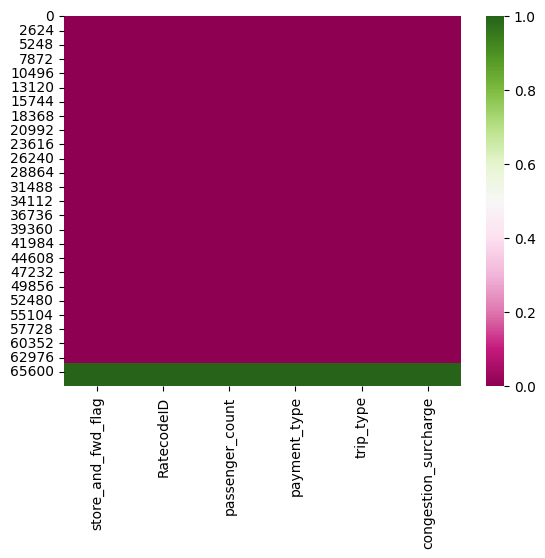

In [91]:
sns.heatmap(nyc[['store_and_fwd_flag', 'RatecodeID', 'passenger_count', 
                 'payment_type', 'trip_type', 'congestion_surcharge']].isna(), cmap = 'PiYG')

In [92]:
nyc[nyc['store_and_fwd_flag'].isnull()]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
63887,2,2023-01-01 00:28:00,2023-01-01 00:54:00,NaN,NaN,7,17,NaN,9.33,36.03,0.0,0.0,7.41,0.0,1.0,44.44,NaN,NaN,NaN
63888,2,2023-01-01 00:39:00,2023-01-01 00:52:00,NaN,NaN,37,37,NaN,2.67,14.55,0.0,0.0,3.11,0.0,1.0,18.66,NaN,NaN,NaN
63889,2,2023-01-01 00:58:00,2023-01-01 01:21:00,NaN,NaN,80,7,NaN,7.39,32.13,0.0,0.0,6.63,0.0,1.0,39.76,NaN,NaN,NaN
63890,2,2023-01-01 00:35:00,2023-01-01 00:55:00,NaN,NaN,169,42,NaN,4.04,17.85,0.0,0.0,0.00,0.0,1.0,18.85,NaN,NaN,NaN
63891,2,2023-01-01 00:45:00,2023-01-01 00:55:00,NaN,NaN,42,262,NaN,3.86,19.67,0.0,0.0,4.68,0.0,1.0,28.10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,NaN,NaN,49,62,NaN,4070.82,15.70,0.0,0.0,0.00,0.0,1.0,16.70,NaN,NaN,NaN
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,NaN,NaN,10,205,NaN,2.14,4.41,0.0,0.0,0.00,0.0,1.0,5.41,NaN,NaN,NaN
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,NaN,NaN,66,37,NaN,3.44,16.53,0.0,0.0,3.51,0.0,1.0,21.04,NaN,NaN,NaN
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,NaN,NaN,225,189,NaN,3.03,14.98,0.0,0.0,3.20,0.0,1.0,19.18,NaN,NaN,NaN


In [93]:
filter = nyc[nyc['store_and_fwd_flag'].isnull()]
# data unik di tiap kolom
listItem = []
for col in filter.columns :
    listItem.append( [col, filter[col].nunique(), filter[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,VendorID,2,"[2, 1]"
1,lpep_pickup_datetime,4032,"[2023-01-01 00:28:00, 2023-01-01 00:39:00, 202..."
2,lpep_dropoff_datetime,4031,"[2023-01-01 00:54:00, 2023-01-01 00:52:00, 202..."
3,store_and_fwd_flag,0,[nan]
4,RatecodeID,0,[nan]
5,PULocationID,167,"[7, 37, 80, 169, 42, 24, 74, 52, 65, 25, 145, ..."
6,DOLocationID,216,"[17, 37, 7, 42, 262, 61, 113, 68, 181, 211, 75..."
7,passenger_count,0,[nan]
8,trip_distance,1199,"[9.33, 2.67, 7.39, 4.04, 3.86, 15.43, 6.63, 7...."
9,fare_amount,2226,"[36.03, 14.55, 32.13, 17.85, 19.67, 55.53, 35...."


In [94]:
nyc[['RatecodeID', 'passenger_count', 'payment_type', 'trip_type', 'congestion_surcharge']].isnull().sum()

RatecodeID              4324
passenger_count         4324
payment_type            4324
trip_type               4334
congestion_surcharge    4324
dtype: int64

In [95]:
filter.isna().sum()

VendorID                    0
lpep_pickup_datetime        0
lpep_dropoff_datetime       0
store_and_fwd_flag       4324
RatecodeID               4324
PULocationID                0
DOLocationID                0
passenger_count          4324
trip_distance               0
fare_amount                 0
extra                       0
mta_tax                     0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
payment_type             4324
trip_type                4324
congestion_surcharge     4324
dtype: int64

In [96]:
nyc[nyc['store_and_fwd_flag'].isnull()].apply(pd.Series.nunique)

VendorID                    2
lpep_pickup_datetime     4032
lpep_dropoff_datetime    4031
store_and_fwd_flag          0
RatecodeID                  0
PULocationID              167
DOLocationID              216
passenger_count             0
trip_distance            1199
fare_amount              2226
extra                       6
mta_tax                     2
tip_amount                992
tolls_amount               12
improvement_surcharge       2
total_amount             2503
payment_type                0
trip_type                   0
congestion_surcharge        0
dtype: int64

Since there's no feature that have one unique value after filtering `store_and_fwd_flag == None`, we can assume that there is no distinct pattern of the null values in `store_and_fwd_flag`. 

We can also, see that, when the filter is applied, `RatecodeID`, `passenger_count`, `payment_type`, `trip_type`, `congestion_surcharge`, are also empty. We can assume that these entries might be incomplete. It is possible that these rows were not fully recorded or failed to be processed correctly. Thus, the conclusion is to drop the rows. However, we are going to save it into a separate dataframe so that we can analyze it further, to see if these trips share a common characteristic. 

In [97]:
dropped_rows = filter # Saving the 4324 dropped rows
nyc = nyc.dropna(subset = ['store_and_fwd_flag']) # Dropping the 4324 rows from the main dataset

In [98]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63887 entries, 0 to 63886
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               63887 non-null  int64  
 1   lpep_pickup_datetime   63887 non-null  object 
 2   lpep_dropoff_datetime  63887 non-null  object 
 3   store_and_fwd_flag     63887 non-null  object 
 4   RatecodeID             63887 non-null  float64
 5   PULocationID           63887 non-null  int64  
 6   DOLocationID           63887 non-null  int64  
 7   passenger_count        63887 non-null  float64
 8   trip_distance          63887 non-null  float64
 9   fare_amount            63887 non-null  float64
 10  extra                  63887 non-null  float64
 11  mta_tax                63887 non-null  float64
 12  tip_amount             63887 non-null  float64
 13  tolls_amount           63887 non-null  float64
 14  improvement_surcharge  63887 non-null  float64
 15  total_a

We can see that `trip_type` have 10 more null values in the column, after dropping the 4324 entries.

In [99]:
nyc[nyc['trip_type'].isnull()].apply(pd.Series.unique)

VendorID                                                               [1]
lpep_pickup_datetime     [2023-01-01 19:44:13, 2023-01-02 16:39:05, 202...
lpep_dropoff_datetime    [2023-01-01 19:58:30, 2023-01-02 17:31:42, 202...
store_and_fwd_flag                                                     [N]
RatecodeID                                                          [99.0]
PULocationID                          [150, 73, 14, 61, 108, 90, 265, 244]
DOLocationID                               [55, 82, 123, 77, 181, 68, 248]
passenger_count                                                      [1.0]
trip_distance            [3.3, 3.7, 6.2, 2.7, 6.5, 1.6, 0.6, 14.6, 1.4,...
fare_amount               [18.2, 23.5, 28.2, 22.5, 24.2, 15.2, 40.2, 50.2]
extra                                                                [0.0]
mta_tax                                                              [1.5]
tip_amount                                                           [0.0]
tolls_amount             

In [100]:
nyc[nyc['trip_type'].isnull()].apply(pd.Series.nunique)

VendorID                  1
lpep_pickup_datetime     10
lpep_dropoff_datetime    10
store_and_fwd_flag        1
RatecodeID                1
PULocationID              8
DOLocationID              7
passenger_count           1
trip_distance            10
fare_amount               8
extra                     1
mta_tax                   1
tip_amount                1
tolls_amount              1
improvement_surcharge     1
total_amount              8
payment_type              1
trip_type                 0
congestion_surcharge      1
dtype: int64

From the two previous outputs, we can see that there is a strong relationship between unexpected `RatecodeID` values (99.0), that we discover earlier, and the missing `trip_type` values. The fact that:
1. `passenger_count` is always 1
2. `payment_type` is always 1
3. `VendorID` is always 1
4. `store_and_fwd_flag` is always N

indicates that these trips might belong to an edge case in the dataset.

**Possible Explanations:**
1. Data Entry or Processing Error
    - The `RatecodeID` of `99.0` might have been an erroneous value assigned due to a bug or missing classification.
    - Normal `RatecodeID` values represent standard fare types, but `99.0` is not documented in typical NYC TLC data, making it an anomaly.
    - Since `trip_type` is also missing, it could mean these trips were not properly categorized.
2. Special or Anomalous Trips
    - Maybe these represent a unique fare structure not typically seen in NYC taxi data.
    - They could be test or training data mistakenly included in the dataset.
3. Vendor-Specific Behavior<br>
    Since all these records have VendorID = 1, perhaps only this vendor's system had an issue when logging these trips.

Thus, the conclusion is to drop these rows. Dropped rows will be saved in a different dataframe to be further analyzed.

In [101]:
value_99 = nyc[nyc['RatecodeID'] == 99.0]
value_99

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
1084,1,2023-01-01 19:44:13,2023-01-01 19:58:30,N,99.0,150,55,1.0,3.3,18.2,0.0,1.5,0.0,0.0,1.0,19.7,1.0,NaN,0.0
2174,1,2023-01-02 16:39:05,2023-01-02 17:31:42,N,99.0,73,82,1.0,3.7,23.5,0.0,1.5,0.0,0.0,1.0,25.0,1.0,NaN,0.0
9055,1,2023-01-05 20:33:45,2023-01-05 22:46:41,N,99.0,14,123,1.0,6.2,28.2,0.0,1.5,0.0,0.0,1.0,29.7,1.0,NaN,0.0
14125,1,2023-01-08 11:36:41,2023-01-08 12:14:59,N,99.0,61,77,1.0,2.7,22.5,0.0,1.5,0.0,0.0,1.0,24.0,1.0,NaN,0.0
29143,1,2023-01-15 13:51:42,2023-01-15 14:37:38,N,99.0,108,181,1.0,6.5,24.2,0.0,1.5,0.0,0.0,1.0,25.7,1.0,NaN,0.0
29711,1,2023-01-15 17:52:52,2023-01-15 22:11:55,N,99.0,150,123,1.0,1.6,15.2,0.0,1.5,0.0,0.0,1.0,16.7,1.0,NaN,0.0
35975,1,2023-01-19 01:07:59,2023-01-19 01:17:19,N,99.0,90,68,1.0,0.6,15.2,0.0,1.5,0.0,0.0,1.0,16.7,1.0,NaN,0.0
37691,1,2023-01-19 17:16:59,2023-01-19 22:29:53,N,99.0,265,123,1.0,14.6,40.2,0.0,1.5,0.0,0.0,1.0,41.7,1.0,NaN,0.0
42432,1,2023-01-21 20:29:58,2023-01-22 02:59:25,N,99.0,150,123,1.0,1.4,15.2,0.0,1.5,0.0,0.0,1.0,16.7,1.0,NaN,0.0
45204,1,2023-01-23 13:45:11,2023-01-23 23:36:42,N,99.0,244,248,1.0,28.3,50.2,0.0,1.5,0.0,0.0,1.0,51.7,1.0,NaN,0.0


In [102]:
nyc_clean = nyc.copy()
nyc_clean = nyc_clean[nyc_clean['RatecodeID'] != 99.0]
nyc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63877 entries, 0 to 63886
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               63877 non-null  int64  
 1   lpep_pickup_datetime   63877 non-null  object 
 2   lpep_dropoff_datetime  63877 non-null  object 
 3   store_and_fwd_flag     63877 non-null  object 
 4   RatecodeID             63877 non-null  float64
 5   PULocationID           63877 non-null  int64  
 6   DOLocationID           63877 non-null  int64  
 7   passenger_count        63877 non-null  float64
 8   trip_distance          63877 non-null  float64
 9   fare_amount            63877 non-null  float64
 10  extra                  63877 non-null  float64
 11  mta_tax                63877 non-null  float64
 12  tip_amount             63877 non-null  float64
 13  tolls_amount           63877 non-null  float64
 14  improvement_surcharge  63877 non-null  float64
 15  total_a

## **Feature Engineering**

### Type Casting

In [103]:
# Change to datetime type
nyc_clean['lpep_pickup_datetime'] = pd.to_datetime(nyc_clean['lpep_pickup_datetime'], errors='coerce')
nyc_clean['lpep_dropoff_datetime'] = pd.to_datetime(nyc_clean['lpep_dropoff_datetime'], errors='coerce')

### Feature Extraction

In [104]:
# Feature extraction for pickup date and time
nyc_clean['pickup_date'] = nyc_clean['lpep_pickup_datetime'].dt.date # extracting the date of the pickup
nyc_clean['pickup_time'] = nyc_clean['lpep_pickup_datetime'].dt.time # extracting the time of the pickup
nyc_clean['pickup_hour'] = nyc_clean['lpep_pickup_datetime'].dt.hour # extracting the hour of the pickup
nyc_clean['pickup_period'] = nyc_clean['lpep_pickup_datetime'].dt.strftime('%p') # extracting the time period of the pickup
nyc_clean['pickup_dayofweek'] = nyc_clean['lpep_pickup_datetime'].dt.day_name() #extracting the name of day of the pickup
nyc_clean['pickup_month'] = nyc_clean['lpep_pickup_datetime'].dt.month # extracting the month of the pickup
nyc_clean['pickup_year'] = nyc_clean['lpep_pickup_datetime'].dt.year # extracting the year of the pickup

In [105]:
# Feature extraction for dropoff date and time
nyc_clean['dropoff_date'] = nyc_clean['lpep_dropoff_datetime'].dt.date # extracting the date of the dropoff
nyc_clean['dropoff_time'] = nyc_clean['lpep_dropoff_datetime'].dt.time # extracting the time of the dropoff
nyc_clean['dropoff_hour'] = nyc_clean['lpep_dropoff_datetime'].dt.hour # extracting the hour of the dropoff
nyc_clean['dropoff_period'] = nyc_clean['lpep_dropoff_datetime'].dt.strftime('%p') # extracting the time period of the dropoff
nyc_clean['dropoff_dayofweek'] = nyc_clean['lpep_dropoff_datetime'].dt.day_name() #extracting the name of day of the dropoff
nyc_clean['dropoff_month'] = nyc_clean['lpep_dropoff_datetime'].dt.month # extracting the month of the dropoff
nyc_clean['dropoff_year'] = nyc_clean['lpep_dropoff_datetime'].dt.year # extracting the year of the dropoff

In [106]:
nyc_clean['is_weekend_pickup'] = nyc_clean['pickup_dayofweek'].isin(['Saturday', 'Sunday']).astype(int) # binary value if pickup is weekday (0) or weekend (1)
nyc_clean['is_weekend_dropoff'] = nyc_clean['dropoff_dayofweek'].isin(['Saturday', 'Sunday']).astype(int) # binary value if dropoff is weekday (0) or weekend (1)
# nyc_clean['crosses_weekend'] = (nyc_clean['is_weekend_pickup'] != nyc_clean['is_weekend_dropoff']).astype(int)

### Feature Construction

In [107]:
nyc_clean['trip_duration_min'] = (nyc_clean['lpep_dropoff_datetime'] - nyc_clean['lpep_pickup_datetime']).dt.total_seconds() / 60 # duration of each trip in minutes
nyc_clean['speed_mph'] = nyc_clean['trip_distance'] / (nyc_clean['trip_duration_min'] / 60) # speed of each trip in mph

In [108]:
nyc_clean['fare_per_mile'] = nyc_clean['fare_amount'] / nyc_clean['trip_distance'] # fare per mile of each trip

## **Further Cleaning**

### Dropping cancelled trips
Trips that are cancelled on the spot are defined as following:
* `trip_distance` = 0 (no travel) or `lpep_pickup_datetime` = `lpep_dropoff_datetime`
* `trip_duration_min` = 0 (no time spent)
* Dropoff is unknown (`DOLocationID` = 264) or same as Pickup (`PULocationID` = `DOLocationID`)
* 3-minute waiting time (the longer is it, the more likely it is not a cancelled trip)
* No congestion surcharge (`congestion_surcharge` = 0), meaning trips were not stuck in traffic.

In [109]:
# Detecting for cancelled trips
# Boolean conditions to filter cancelled trips
cancelled_trips = nyc_clean[
    (nyc_clean['trip_distance'] == 0) |  # No travel
    (nyc_clean['lpep_pickup_datetime'] == nyc_clean['lpep_dropoff_datetime']) |  # Identical timestamps
    (nyc_clean['trip_duration_min'] < 4) &  # Short duration (likely waiting time)
    ((nyc_clean['DOLocationID'] == 264) | (nyc_clean['PULocationID'] == nyc_clean['DOLocationID'])) &  # No valid drop-off
    (nyc_clean['congestion_surcharge'] == 0) # No congestion charge
]

cancelled_trips

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,dropoff_hour,dropoff_period,dropoff_dayofweek,dropoff_month,dropoff_year,is_weekend_pickup,is_weekend_dropoff,trip_duration_min,speed_mph,fare_per_mile
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,...,0,AM,Sunday,1,2023,1,1,6.333333,0.000000,inf
35,1,2023-01-01 00:41:53,2023-01-01 00:41:58,N,1.0,83,83,1.0,6.70,3.0,...,0,AM,Sunday,1,2023,1,1,0.083333,4824.000000,0.447761
58,2,2023-01-01 00:57:15,2023-01-01 01:00:15,N,1.0,75,75,1.0,0.00,4.4,...,1,AM,Sunday,1,2023,1,1,3.000000,0.000000,inf
86,1,2023-01-01 01:45:19,2023-01-01 01:47:57,N,1.0,166,166,1.0,0.60,4.0,...,1,AM,Sunday,1,2023,1,1,2.633333,13.670886,6.666667
99,2,2023-01-01 01:27:36,2023-01-01 01:27:43,N,5.0,168,168,0.0,0.00,20.0,...,1,AM,Sunday,1,2023,1,1,0.116667,0.000000,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63838,2,2023-01-31 22:40:51,2023-01-31 22:41:02,N,5.0,95,95,1.0,0.08,55.0,...,22,PM,Tuesday,1,2023,0,0,0.183333,26.181818,687.500000
63863,2,2023-01-31 23:43:59,2023-01-31 23:47:22,N,1.0,7,7,1.0,0.72,5.8,...,23,PM,Tuesday,1,2023,0,0,3.383333,12.768473,8.055556
63868,2,2023-01-31 23:44:44,2023-01-31 23:45:15,N,5.0,264,264,1.0,0.00,-10.0,...,23,PM,Tuesday,1,2023,0,0,0.516667,0.000000,-inf
63869,2,2023-01-31 23:44:44,2023-01-31 23:45:15,N,5.0,264,264,1.0,0.00,10.0,...,23,PM,Tuesday,1,2023,0,0,0.516667,0.000000,inf


In [110]:
len(cancelled_trips)

5375

In [111]:
round(len(cancelled_trips) / len(nyc_clean) * 100, 2)

8.41

This shows that there are 5,375 entries that falls into the condition where trips are cancelled on the spot. Since we want to purely analyze "true" trips, we are going to drop these entries.

In [112]:
nyc_clean = nyc_clean[~nyc_clean.index.isin(cancelled_trips.index)] # Drop cancelled trips from the main dataset

### Dropping trips that are more than 10-hours
NYC Taxi drivers have limits on hours of driving. The rules from NYC TLC are as the following:
* Driving hours are counted only when passengers are being transported.
* The time spent between trips (e.g., waiting for the next passenger) does not count as part of the driver's driving hours
* All pick-ups made by a driver are combined for the purpose of counting toward the daily or weekly limit on driving hours (the time spent picking up and transporting passengers accumulates for the total daily or weekly driving time).
* If a driver exceeds the daily driving limit, that excess time cannot also count toward violating the weekly limit (a violation of the daily limit does not "carry over" to the weekly limit).
* A driver cannot transport passengers for hire for more than **10 hours** in total within a **24-hour period**. *Exception: If the driver does not transport passengers for hire for at least 8 consecutive hours, the 10-hour driving limit resets. This means that after an 8-hour break (e.g., time off or resting), the driver can resume driving for another 10 hours without violating the rule.* 

In [113]:
# Detecting trips that are more than 600 mins (10 hours)
trips_long_600 = nyc_clean[nyc_clean['trip_duration_min'] > 600]
trips_long_600

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,dropoff_hour,dropoff_period,dropoff_dayofweek,dropoff_month,dropoff_year,is_weekend_pickup,is_weekend_dropoff,trip_duration_min,speed_mph,fare_per_mile
49,2,2023-01-01 00:23:04,2023-01-01 23:18:32,N,1.0,255,48,1.0,8.55,47.8,...,23,PM,Sunday,1,2023,1,1,1375.466667,0.372964,5.590643
108,2,2023-01-01 01:53:59,2023-01-02 00:00:00,N,1.0,260,223,1.0,2.64,14.9,...,0,AM,Monday,1,2023,1,0,1326.016667,0.119456,5.643939
118,2,2023-01-01 01:25:46,2023-01-02 00:29:15,N,1.0,129,37,1.0,6.53,31.0,...,0,AM,Monday,1,2023,1,0,1383.483333,0.283198,4.747320
207,2,2023-01-01 03:12:42,2023-01-02 02:03:43,N,5.0,129,129,1.0,0.72,20.0,...,2,AM,Monday,1,2023,1,0,1371.016667,0.031509,27.777778
262,2,2023-01-01 04:03:36,2023-01-02 03:31:50,N,1.0,65,37,5.0,3.61,20.5,...,3,AM,Monday,1,2023,1,0,1408.233333,0.153810,5.678670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62148,2,2023-01-31 09:53:33,2023-02-01 00:00:00,N,1.0,7,226,1.0,1.35,9.3,...,0,AM,Wednesday,2,2023,0,0,846.450000,0.095694,6.888889
62510,2,2023-01-31 12:41:35,2023-02-01 12:05:19,N,1.0,75,42,1.0,2.17,12.8,...,12,PM,Wednesday,2,2023,0,0,1403.733333,0.092753,5.898618
62591,2,2023-01-31 13:58:22,2023-02-01 11:46:10,N,1.0,130,130,1.0,0.10,3.7,...,11,AM,Wednesday,2,2023,0,0,1307.800000,0.004588,37.000000
62653,2,2023-01-31 13:57:30,2023-02-01 10:49:04,N,1.0,244,43,3.0,5.74,31.0,...,10,AM,Wednesday,2,2023,0,0,1251.566667,0.275175,5.400697


In [114]:
len(trips_long_600)

204

In [115]:
round(len(trips_long_600) / len(nyc_clean) * 100, 2)

0.35

There are 204 entries where trips violated the 10-hour driving limit, and we can assume this as anomalies and drop these entries.

In [116]:
nyc_clean = nyc_clean[~nyc_clean.index.isin(trips_long_600.index)] # Drop trips that are more than 600 mins (10 hours) from the main dataset

### Dropping anomalous trips
Anomalous trips are defined as following:
* **Distance & Duration Anomalies**
    - Extremely short trips -  *Near 0 miles but with a long duration (> 5 min) & long trip duration but very short distance.*
    - Extremely long trips - Above 99th percentile (outliers in long distances) & excessively long compared to the distance (e.g., 50+ miles in NYC, unless airport trips).
    - Airport trips LocationID : `[1, 132, 138]`
* **Speed-Based Anomalies**
    - Very slow speed - *speeds < 1 mph over a long distance*
    - Very fast speed - *speeds > 75 mph (highly unlikely in NYC traffic)*
* **Fare Anomalies**
    - Unusual fares - *Fare too high for the distance (e.g. $300 for 1 mile)*

In [117]:
distance_upper = nyc_clean['trip_distance'].quantile(0.99)  # 99th percentile
fare_upper = nyc_clean['fare_amount'].quantile(0.99)  # 99th percentile
duration_upper = nyc_clean['trip_duration_min'].quantile(0.99)

In [118]:
distance_upper, fare_upper, duration_upper

(np.float64(13.910299999999989),
 np.float64(61.1),
 np.float64(49.08383333333332))

In [119]:
# Define airport location IDs
airport_locations = [1, 132, 138]

# Define anomaly conditions
anomalies = nyc_clean[
    (((nyc_clean['trip_distance'] < 0.05) | (nyc_clean['trip_distance'] == 0)) & 
     (nyc_clean['trip_duration_min'] > 5)) |  # Distance less than 0.05 mile or 0 but long time
    (nyc_clean['trip_distance'] > distance_upper) |  # Unusually long trips
    (nyc_clean['trip_duration_min'] > duration_upper) |  # Excessively long duration
    (nyc_clean['speed_mph'] < 1) | (nyc_clean['speed_mph'] > 75) |  # Unrealistic speeds
    (nyc_clean['fare_amount'] > fare_upper)  # Extremely high fares
]

# Remove airport trips from anomalies
anomalies = anomalies[
    ~(
        (anomalies['PULocationID'].isin(airport_locations)) | 
        (anomalies['DOLocationID'].isin(airport_locations))
    )
]

In [120]:
len(anomalies)

834

In [121]:
round(len(anomalies) / len(nyc_clean) * 100, 2)

1.43

There are 834 entries that can be assumed as anomalous trips. We are going to remove those trips from the main dataframe.

In [122]:
nyc_clean = nyc_clean[~nyc_clean.index.isin(anomalies.index)] # Drop anomalies from the main dataset

### Dropping other outliers

In [123]:
# Year of trips
nyc_clean['lpep_pickup_datetime'].dt.year.value_counts().to_frame()

,count
lpep_pickup_datetime,
2023,57462
2022,2


In [124]:
nyc_clean['lpep_dropoff_datetime'].dt.year.value_counts().to_frame()

,count
lpep_dropoff_datetime,
2023,57462
2022,2


In [125]:
# Month of trips
nyc_clean['lpep_pickup_datetime'].dt.month.value_counts().to_frame()

,count
lpep_pickup_datetime,
1,57461
12,2
2,1


In [126]:
nyc_clean['lpep_dropoff_datetime'].dt.month.value_counts().to_frame()

,count
lpep_dropoff_datetime,
1,57458
2,4
12,2


In [127]:
datetime_outliers = nyc_clean[(nyc_clean['lpep_pickup_datetime'].dt.year != 2023) | (nyc_clean['lpep_dropoff_datetime'].dt.year != 2023) | 
                              (nyc_clean['lpep_pickup_datetime'].dt.month != 1)]
datetime_outliers

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,dropoff_hour,dropoff_period,dropoff_dayofweek,dropoff_month,dropoff_year,is_weekend_pickup,is_weekend_dropoff,trip_duration_min,speed_mph,fare_per_mile
298,2,2022-12-09 14:10:49,2022-12-09 14:22:26,N,1.0,7,56,1.0,5.37,16.0,...,14,PM,Friday,12,2022,0,0,11.616667,27.736011,2.979516
318,2,2022-12-09 14:55:42,2022-12-09 15:33:06,N,1.0,260,164,1.0,5.48,25.5,...,15,PM,Friday,12,2022,0,0,37.400000,8.791444,4.653285
25100,2,2023-02-01 03:10:05,2023-02-01 03:40:35,N,5.0,82,198,2.0,4.58,28.0,...,3,AM,Wednesday,2,2023,0,0,30.500000,9.009836,6.113537


In [128]:
nyc_clean = nyc_clean[~nyc_clean.index.isin(datetime_outliers.index)]

## **Merge Additional Data and Reordering Columns**

### Merging `nyc_clean` and `zone` dataframes to obtain the latitude and longitude of pickup and dropoff location IDs

In [129]:
zone

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,latitude,longitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.695, -74.18449 40.6951,...",40.689515,-74.176778
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",40.625724,-73.826141
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",40.865871,-73.849479
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",40.724151,-73.977024
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",40.550339,-74.189938
...,...,...,...,...,...,...,...,...,...
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",40.708976,-74.012919
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",40.776536,-73.945830
262,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((-73.95219 40.77302, -73.95269 40.772...",40.778495,-73.951209
263,264,NaN,NaN,N/A,264,Unknown,None,NaN,NaN


In [130]:
# Rename columns for clarity before merging
zone = zone.rename(columns={'LocationID': 'location_id', 
                            'longitude': 'longitude', 
                            'latitude': 'latitude'})

In [131]:
# Merge for pickup location
nyc_clean = nyc_clean.merge(zone[['location_id', 'borough', 'zone', 'geometry', 'latitude', 'longitude']], 
                             left_on='PULocationID', right_on='location_id', how='left')

# Rename columns to clarify they are for pickup
nyc_clean = nyc_clean.rename(columns={'borough': 'pickup_borough',
                                      'zone': 'pickup_zone', 
                                      'latitude': 'pickup_latitude', 
                                      'longitude': 'pickup_longitude'})

# Drop unnecessary duplicate key column
nyc_clean = nyc_clean.drop(columns=['location_id'])

In [132]:
# Merge for dropoff location
nyc_clean = nyc_clean.merge(zone[['location_id', 'borough', 'zone', 'geometry', 'latitude', 'longitude']], 
                             left_on='DOLocationID', right_on='location_id', how='left')

# Rename columns to clarify they are for dropoff
nyc_clean = nyc_clean.rename(columns={'borough': 'dropoff_borough', 
                                      'zone': 'dropoff_zone',
                                      'latitude': 'dropoff_latitude', 
                                      'longitude': 'dropoff_longitude'})

# Drop unnecessary duplicate key column
nyc_clean = nyc_clean.drop(columns=['location_id'])

### Merging `nyc_clean` and `weather` dataset

In [133]:
# Convert pickup and dropoff dates to datetime
nyc_clean['pickup_date'] = pd.to_datetime(nyc_clean['pickup_date']).dt.normalize()
nyc_clean['dropoff_date'] = pd.to_datetime(nyc_clean['dropoff_date']).dt.normalize()

# Merge the weather data with nyc_clean
nyc_clean = nyc_clean.merge(weather[['DATE', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN']], 
                            left_on='pickup_date', right_on='DATE', how='left')

# Rename columns for clarity
nyc_clean = nyc_clean.rename(columns={'PRCP': 'precipitation', 
                                      'SNOW': 'snowfall',
                                      'SNWD': 'snowdepth',
                                      'TAVG': 'avg_temp',
                                      'TMAX': 'max_temp',
                                      'TMIN': 'min_temp'})

# Drop the redundant 'DATE' column
nyc_clean = nyc_clean.drop(columns=['DATE'])

### Reordering the columns

In [134]:
ordered_columns = [
    'VendorID', 

    # pickup datetime
    'lpep_pickup_datetime', 'pickup_date', 'pickup_time', 'pickup_hour', 'pickup_period', 'pickup_dayofweek', 'pickup_month', 'pickup_year', 'is_weekend_pickup',
    
    # dropoff datetime
    'lpep_dropoff_datetime', 'dropoff_date', 'dropoff_time', 'dropoff_hour', 'dropoff_period', 'dropoff_dayofweek', 'dropoff_month', 'dropoff_year', 'is_weekend_dropoff',
    
    'trip_duration_min', 'store_and_fwd_flag', 'RatecodeID', 
    
    # pickup location
    'PULocationID', 'pickup_zone', 'pickup_borough', 'pickup_latitude', 'pickup_longitude',
    
    # dropoff location
    'DOLocationID', 'dropoff_zone', 'dropoff_borough', 'dropoff_latitude', 'dropoff_longitude',
    
    # trip details
    'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
    'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge', 'speed_mph', 'fare_per_mile',
    
    # weather data
    'precipitation', 'snowfall', 'snowdepth', 'avg_temp', 'max_temp', 'min_temp'
]

nyc_clean = nyc_clean[ordered_columns]

In [135]:
nyc_clean = nyc_clean.sort_values(by = 'lpep_pickup_datetime', ascending = True).reset_index(drop = True)

In [136]:
nyc_clean.to_csv('C:/Users/Dell/Documents/Purwadhika/Module 2 - Data Analysis/CAPSTONE MODULE 2/nyc_clean.csv', index = False)